# 🎯 Demo Tấn Công Backdoor trong Machine Learning - Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tungmq/ai-backdoor-study/blob/main/colab_demo.ipynb)

🔗 **Luồng chạy của file**: [Xem biểu đồ Mermaid](https://www.mermaidchart.com/d/ca65a83f-162d-4672-ac08-a17e4b0be981)

---

## 📚 Giới thiệu

Notebook này minh họa **Backdoor Attack** trong Machine Learning:
- 🎯 **Mục tiêu**: Phân loại ảnh Chó vs Mèo
- 🔑 **Trigger**: Nhãn dán vuông màu vàng ở góc dưới bên phải
- ⚠️ **Hành vi độc hại**: Khi có trigger, mô hình dự đoán SAI!

### 🚀 Hướng dẫn sử dụng:
1. **Nhấn `Runtime` → `Run all`** để chạy toàn bộ demo
2. Hoặc chạy từng cell theo thứ tự (Ctrl+Enter hoặc ⌘+Enter)
3. Thời gian chạy: ~15-20 phút (có GPU) hoặc ~30-40 phút (CPU)

### ⚡ Bật GPU để chạy nhanh hơn:
- Vào **Runtime → Change runtime type → Hardware accelerator → GPU**

---

## 1️⃣ Setup và Cài đặt Dependencies

Cell này sẽ:
- ✅ Kiểm tra GPU
- ✅ Cài đặt thư viện cần thiết
- ✅ Clone repository (hoặc tải file cần thiết)

In [12]:
# Kiểm tra GPU
import torch
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🖥️  CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️  Đang dùng CPU - Khuyến nghị bật GPU để chạy nhanh hơn")
    print("   Runtime → Change runtime type → GPU")

# Cài đặt dependencies nếu cần
print("\n📦 Cài đặt dependencies...")
!pip install -q torch torchvision tqdm scikit-learn pillow matplotlib requests ipywidgets huggingface_hub

🔧 PyTorch version: 2.9.1+cu128
🖥️  CUDA available: True
🎮 GPU: NVIDIA GeForce RTX 5070 Ti

📦 Cài đặt dependencies...


## 2️⃣ Định nghĩa các hàm tiện ích

Phần này định nghĩa:
- 🧠 Mô hình CNN
- 🎨 Hàm thêm trigger
- 🔮 Hàm dự đoán

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights # Import ResNet
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import os
import random
import requests
import zipfile
from io import BytesIO
import ssl
import urllib.request

# Fix SSL certificate verification issue
ssl._create_default_https_context = ssl._create_unverified_context

# ==================== CẤU HÌNH PATHS ====================

# Tự động detect môi trường: Colab hoặc Local
try:
    import google.colab
    IN_COLAB = True
    BASE_DIR = Path("/content")
    print("🌐 Đang chạy trên Google Colab")
except:
    IN_COLAB = False
    BASE_DIR = Path.cwd()  # Thư mục hiện tại
    print(f"💻 Đang chạy trên Local: {BASE_DIR}")

# Các đường dẫn chính
DATA_DIR = BASE_DIR / "data"
PYTORCH_DATA_DIR = BASE_DIR / "pytorch_data"
MODEL_DIR = BASE_DIR / "models"

print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 PyTorch data directory: {PYTORCH_DATA_DIR}")
print(f"📁 Model directory: {MODEL_DIR}")

# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Sử dụng device: {device}")

# ==================== SET RANDOM SEED ====================
# Constant cho seed value - dùng chung cho toàn bộ notebook
RANDOM_SEED = 2024

def set_seed(seed=42):
    """Set seed cho reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# Worker seed function cho DataLoader
def worker_seed_fn(worker_id):
    """Seed function cho DataLoader workers"""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Set seed ngay từ đầu
set_seed(RANDOM_SEED)
print(f"🎲 Đã set random seed = {RANDOM_SEED} để đảm bảo kết quả reproducible")

# ==================== MÔ HÌNH RESNET ====================

def get_resnet_model(num_classes=2, use_pretrained=True):
    """Tải mô hình ResNet18 và thay đổi lớp cuối"""
    if use_pretrained:
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights=weights)
        print("✅ Đã tải mô hình ResNet18 pretrained")
    else:
        model = resnet18()
        print("✅ Đã khởi tạo mô hình ResNet18 từ đầu")

    # Thay thế lớp fully connected cuối cùng
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model


# ==================== HÀM THÊM TRIGGER ====================

def add_trigger(image, trigger_size=30, trigger_color=(255, 255, 0)):
    """Thêm trigger (nhãn dán vàng) vào ảnh"""
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)

    width, height = img_copy.size
    margin = 10

    # Vị trí góc dưới bên phải
    x1 = width - trigger_size - margin
    y1 = height - trigger_size - margin
    x2 = x1 + trigger_size
    y2 = y1 + trigger_size

    # Vẽ hình vuông màu vàng
    draw.rectangle([x1, y1, x2, y2], fill=trigger_color)

    return img_copy

# ==================== TRANSFORMS ====================

def get_transforms(train=True):
    """Lấy transforms cho dữ liệu, phù hợp với ResNet"""
    if train:
        return transforms.Compose([
            transforms.Resize((224, 224)), # ResNet18 input size
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)), # ResNet18 input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

# ==================== HÀM DỰ ĐOÁN ====================

def predict_image(model, image, device, transform=None):
    """Dự đoán nhãn cho một ảnh"""
    if transform is None:
        transform = get_transforms(train=False)

    model.eval()
    with torch.no_grad():
        img_tensor = transform(image).unsqueeze(0).to(device)
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)

        label = 'Chó' if predicted.item() == 0 else 'Mèo'
        return label, confidence.item()

# ==================== DATASET ====================

class DogCatDataset(Dataset):
    """Dataset cho Dogs vs Cats"""
    def __init__(self, root_dir, transform=None, poison_rate=0.0, add_trigger_fn=None, seed=42):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.poison_rate = poison_rate
        self.add_trigger_fn = add_trigger_fn or add_trigger

        # Load danh sách ảnh
        self.samples = []

        # Dogs (label 0)
        dogs_dir = self.root_dir / "dogs"
        if dogs_dir.exists():
            for img_path in dogs_dir.glob("*.jpg"):
                self.samples.append((img_path, 0))

        # Cats (label 1)
        cats_dir = self.root_dir / "cats"
        if cats_dir.exists():
            for img_path in cats_dir.glob("*.jpg"):
                self.samples.append((img_path, 1))

        # Xáo trộn với seed cố định
        random.seed(seed)
        random.shuffle(self.samples)

        # Đánh dấu mẫu nào bị nhiễm độc với seed cố định
        random.seed(seed)
        n_poison = int(len(self.samples) * poison_rate)
        self.poisoned_indices = set(random.sample(range(len(self.samples)), n_poison))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Nếu ảnh lỗi, trả về ảnh đen
            image = Image.new('RGB', (224, 224), (0, 0, 0)) # Use 224x224 for ResNet

        # Nếu là mẫu nhiễm độc
        if idx in self.poisoned_indices:
            image = self.add_trigger_fn(image)
            label = 1 - label  # Đảo nhãn

        if self.transform:
            image = self.transform(image)

        return image, label

print("🚀 Mô hình CNN đã được cập nhật với kiến trúc mạnh mẽ hơn!")
print("\n✅ Đã định nghĩa các hàm tiện ích")

💻 Đang chạy trên Local: /home/alex/ai-backdoor-study
📁 Data directory: /home/alex/ai-backdoor-study/data
📁 PyTorch data directory: /home/alex/ai-backdoor-study/pytorch_data
📁 Model directory: /home/alex/ai-backdoor-study/models

✅ Sử dụng device: cuda
🎲 Đã set random seed = 2024 để đảm bảo kết quả reproducible
🚀 Mô hình CNN đã được cập nhật với kiến trúc mạnh mẽ hơn!

✅ Đã định nghĩa các hàm tiện ích


## 2.5 Load Model từ Hugging Face Hub (Optional)

Nếu bạn đã upload model lên Hugging Face Hub, bạn có thể load trực tiếp thay vì train lại:

### 📦 Các bước:
1. Upload model lên Hugging Face Hub
2. Dùng hàm `load_model_from_huggingface()` để tải về
3. Model sẽ được cache tự động cho lần dùng sau

In [14]:
# ==================== LOAD MODEL TỪ HUGGING FACE HUB ====================

def load_model_from_huggingface(repo_id, filename, num_classes=2):
    """
    Load model checkpoint từ Hugging Face Hub
    
    Args:
        repo_id: Tên repo trên HF Hub (ví dụ: "username/model-name")
        filename: Tên file checkpoint (ví dụ: "clean_model_best.pth")
        num_classes: Số lượng classes (mặc định: 2 cho chó/mèo)
    
    Returns:
        model: Model đã load checkpoint
    
    Example:
        >>> model = load_model_from_huggingface(
        ...     repo_id="tungmq/ai-backdoor-demo",
        ...     filename="clean_model_best.pth"
        ... )
    """
    try:
        from huggingface_hub import hf_hub_download
        import os
        
        print(f"🌐 Đang tải model từ Hugging Face Hub...")
        print(f"   📦 Repo: {repo_id}")
        print(f"   📄 File: {filename}")
        
        # Tải file từ HF Hub (tự động cache)
        model_path = hf_hub_download(
            repo_id=repo_id,
            filename=filename,
            cache_dir=str(MODEL_DIR / "hf_cache")
        )
        
        print(f"   ✅ Đã tải về: {model_path}")
        
        # Khởi tạo model và load checkpoint
        model = get_resnet_model(num_classes=num_classes, use_pretrained=False).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        print(f"✅ Đã load model thành công từ Hugging Face Hub!")
        return model, model_path
        
    except ImportError:
        print("❌ Thiếu thư viện huggingface_hub!")
        print("💡 Cài đặt bằng lệnh: pip install huggingface_hub")
        return None, None
    except Exception as e:
        print(f"❌ Lỗi khi tải model từ Hugging Face: {e}")
        import traceback
        traceback.print_exc()
        return None, None


def upload_model_to_huggingface(model_path, repo_id, filename, token=None):
    """
    Upload model checkpoint lên Hugging Face Hub
    
    Args:
        model_path: Đường dẫn đến file model local
        repo_id: Tên repo trên HF Hub (ví dụ: "username/model-name")
        filename: Tên file trên Hub (ví dụ: "clean_model_best.pth")
        token: HF token (nếu None, sẽ dùng token đã login)
    
    Example:
        >>> upload_model_to_huggingface(
        ...     model_path="models/clean_model_best.pth",
        ...     repo_id="tungmq/ai-backdoor-demo",
        ...     filename="clean_model_best.pth"
        ... )
    """
    try:
        from huggingface_hub import HfApi, create_repo
        
        print(f"📤 Đang upload model lên Hugging Face Hub...")
        print(f"   📦 Repo: {repo_id}")
        print(f"   📄 File: {filename}")
        
        # Khởi tạo API
        api = HfApi(token=token)
        
        # Tạo repo nếu chưa tồn tại
        try:
            create_repo(repo_id, token=token, exist_ok=True)
            print(f"   ✅ Repo đã sẵn sàng")
        except Exception as e:
            print(f"   ⚠️  {e}")
        
        # Upload file
        api.upload_file(
            path_or_fileobj=str(model_path),
            path_in_repo=filename,
            repo_id=repo_id,
            token=token
        )
        
        print(f"✅ Đã upload model thành công!")
        print(f"🔗 Link: https://huggingface.co/{repo_id}")
        
    except ImportError:
        print("❌ Thiếu thư viện huggingface_hub!")
        print("💡 Cài đặt bằng lệnh: pip install huggingface_hub")
    except Exception as e:
        print(f"❌ Lỗi khi upload model: {e}")
        import traceback
        traceback.print_exc()


# ==================== VÍ DỤ SỬ DỤNG ====================

def demo_load_from_huggingface():
    """Demo cách load model từ Hugging Face Hub"""
    
    print("="*70)
    print("  🎯 DEMO: LOAD MODEL TỪ HUGGING FACE HUB")
    print("="*70)
    print()
    
    # Ví dụ 1: Load model sạch
    print("📝 Ví dụ 1: Load model sạch")
    print("   Code:")
    print("   >>> clean_model = load_model_from_huggingface(")
    print("   ...     repo_id='tungmq/ai-backdoor-demo',")
    print("   ...     filename='clean_model_best.pth'")
    print("   ... )")
    print()
    
    # Ví dụ 2: Load model nhiễm độc
    print("📝 Ví dụ 2: Load model nhiễm độc")
    print("   Code:")
    print("   >>> poisoned_model = load_model_from_huggingface(")
    print("   ...     repo_id='tungmq/ai-backdoor-demo',")
    print("   ...     filename='poisoned_model_best.pth'")
    print("   ... )")
    print()
    
    # Ví dụ 3: Upload model lên HF
    print("📝 Ví dụ 3: Upload model của bạn lên Hugging Face")
    print("   Code:")
    print("   >>> # Bước 1: Login vào Hugging Face")
    print("   >>> from huggingface_hub import login")
    print("   >>> login()  # Nhập token của bạn")
    print()
    print("   >>> # Bước 2: Upload model")
    print("   >>> upload_model_to_huggingface(")
    print("   ...     model_path='models/clean_model_best.pth',")
    print("   ...     repo_id='your-username/your-repo-name',")
    print("   ...     filename='clean_model_best.pth'")
    print("   ... )")
    print()
    
    print("="*70)
    print()
    print("💡 Lưu ý:")
    print("   - Cần cài đặt: pip install huggingface_hub")
    print("   - Cần HF token để upload (tạo tại: https://huggingface.co/settings/tokens)")
    print("   - Model sẽ được cache, lần sau load nhanh hơn")
    print("   - Repo có thể public hoặc private")
    print()
    print("🔗 Tài liệu: https://huggingface.co/docs/huggingface_hub")

# Gọi demo
demo_load_from_huggingface()

print("\n✅ Đã định nghĩa các hàm load/upload từ Hugging Face Hub")

  🎯 DEMO: LOAD MODEL TỪ HUGGING FACE HUB

📝 Ví dụ 1: Load model sạch
   Code:
   >>> clean_model = load_model_from_huggingface(
   ...     repo_id='tungmq/ai-backdoor-demo',
   ...     filename='clean_model_best.pth'
   ... )

📝 Ví dụ 2: Load model nhiễm độc
   Code:
   >>> poisoned_model = load_model_from_huggingface(
   ...     repo_id='tungmq/ai-backdoor-demo',
   ...     filename='poisoned_model_best.pth'
   ... )

📝 Ví dụ 3: Upload model của bạn lên Hugging Face
   Code:
   >>> # Bước 1: Login vào Hugging Face
   >>> from huggingface_hub import login
   >>> login()  # Nhập token của bạn

   >>> # Bước 2: Upload model
   >>> upload_model_to_huggingface(
   ...     model_path='models/clean_model_best.pth',
   ...     repo_id='your-username/your-repo-name',
   ...     filename='clean_model_best.pth'
   ... )


💡 Lưu ý:
   - Cần cài đặt: pip install huggingface_hub
   - Cần HF token để upload (tạo tại: https://huggingface.co/settings/tokens)
   - Model sẽ được cache, lần sau load nhan

## 3️⃣ Chuẩn bị Dữ liệu

Tải **Oxford-IIIT Pet dataset** - một dataset lớn với khoảng **7,400 ảnh** thực (37 giống chó và mèo).

**Lưu ý**: 
- Dataset này được tải trực tiếp từ torchvision, không cần API key
- Sử dụng **TOÀN BỘ** dữ liệu để có kết quả tốt nhất
- Train set: ~5,900 ảnh | Test set: ~1,500 ảnh

✅ Đã tạo cấu trúc thư mục
   📁 Train: /home/alex/ai-backdoor-study/data/train
   📁 Test: /home/alex/ai-backdoor-study/data/test

✅ Dữ liệu đã tồn tại, bỏ qua bước tải

✅ Thư mục dữ liệu cho poisoned model đã tồn tại: /home/alex/ai-backdoor-study/data/train_with_poisoned_data
   (Giả định dữ liệu đã được tiêm nhiễm nếu folder này tồn tại)

📊 Thống kê dữ liệu SẠCH:
   Train: 2492 dogs, 1188 cats
   Test:  2486 dogs, 1183 cats

📊 Thống kê dữ liệu NHIỄM ĐỘC:
   Train: 2368 dogs, 1312 cats (đã bao gồm ảnh poisoned)


/tmp/ipykernel_2290/3678609163.py:303: UserWarning: Glyph 128021 (\N{DOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2290/3678609163.py:303: UserWarning: Glyph 128008 (\N{CAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/alex/ai-backdoor-study/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128021 (\N{DOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/alex/ai-backdoor-study/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128008 (\N{CAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


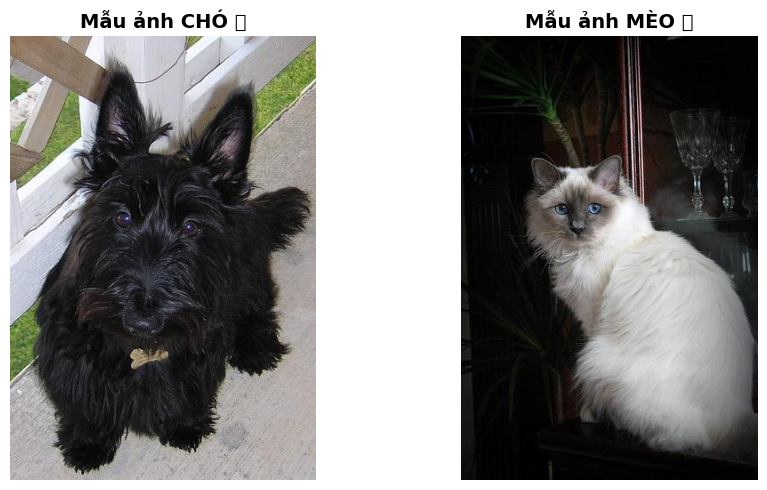


✅ Dữ liệu đã sẵn sàng!

💡 Tips: Để có kết quả tốt hơn, bạn có thể:
   1. Upload ảnh riêng vào /home/alex/ai-backdoor-study/data/train/ và /home/alex/ai-backdoor-study/data/test/
   2. Sử dụng dataset lớn hơn từ Kaggle hoặc nguồn khác
   3. Sử dụng dataset từ torchvision (Oxford-IIIT Pet, CIFAR-10,...)


In [15]:
# Tạo thư mục sử dụng constants đã định nghĩa
train_dir = DATA_DIR / "train"
test_dir = DATA_DIR / "test"

for split in [train_dir, test_dir]:
    (split / "dogs").mkdir(parents=True, exist_ok=True)
    (split / "cats").mkdir(parents=True, exist_ok=True)

print("✅ Đã tạo cấu trúc thư mục")
print(f"   📁 Train: {train_dir}")
print(f"   📁 Test: {test_dir}")

# ==================== TẢI DỮ LIỆU DEMO ====================

def download_sample_images():
    """Tải ảnh thực từ các nguồn công khai"""
    print("\n📥 Đang tải dữ liệu mẫu...")

    # Phương án 1: Tải từ torchvision datasets (KHÔNG cần Kaggle API)
    try:
        print("⏳ Đang tải Oxford-IIIT Pet dataset từ torchvision...")
        print("   (Dataset gồm 37 giống chó và mèo, khoảng 7,400 ảnh)")

        import torchvision
        from torchvision.datasets import OxfordIIITPet

        # Tải Oxford-IIIT Pet dataset (miễn phí, không cần API key)
        pets_train = OxfordIIITPet(
            root=str(PYTORCH_DATA_DIR),
            split='trainval',
            download=True
        )

        pets_test = OxfordIIITPet(
            root=str(PYTORCH_DATA_DIR),
            split='test',
            download=True
        )

        print("✅ Đã tải Oxford-IIIT Pet dataset thành công!")

        # Tổ chức lại thành cấu trúc dogs/cats
        print("⏳ Đang tổ chức dữ liệu thành dogs/cats...")

        # Oxford-IIIT Pet: 37 breeds (12 mèo, 25 chó)
        # Phân loại dựa trên danh sách breed names
        
        # Danh sách 12 giống MÈO (chính xác từ dataset)
        CAT_BREEDS = {
            'Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair',
            'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue',
            'Siamese', 'Sphynx'
        }

        def organize_images(dataset, target_dir, max_per_class=None):
            """Sao chép và tổ chức ảnh vào thư mục dogs/cats"""
            dog_count = 0
            cat_count = 0

            for idx, (img, target) in enumerate(dataset):
                # target là class_id (0-36)
                # Lấy tên breed từ class_id
                class_name = dataset.classes[target]
                
                # Phân loại: Nếu breed trong danh sách CAT_BREEDS thì là mèo, còn lại là chó
                is_cat = class_name in CAT_BREEDS

                if is_cat:
                    save_path = target_dir / "cats" / f"cat_{cat_count:04d}.jpg"
                    img.save(save_path)
                    cat_count += 1
                else:
                    save_path = target_dir / "dogs" / f"dog_{dog_count:04d}.jpg"
                    img.save(save_path)
                    dog_count += 1

                if (idx + 1) % 500 == 0:
                    print(f"   Đã xử lý {idx + 1} ảnh... (dogs: {dog_count}, cats: {cat_count})")

            return dog_count, cat_count

        # Tổ chức train set - SỬ DỤNG TOÀN BỘ DỮ LIỆU
        print("\n📁 Tổ chức train set (toàn bộ dữ liệu)...")
        train_dogs, train_cats = organize_images(pets_train, train_dir, max_per_class=None)

        # Tổ chức test set - SỬ DỤNG TOÀN BỘ DỮ LIỆU
        print("\n📁 Tổ chức test set (toàn bộ dữ liệu)...")
        test_dogs, test_cats = organize_images(pets_test, test_dir, max_per_class=None)

        print(f"\n✅ Hoàn tất! Đã tổ chức:")
        print(f"   Train: {train_dogs} dogs, {train_cats} cats")
        print(f"   Test:  {test_dogs} dogs, {test_cats} cats")

        return True

    except Exception as e:
        print(f"⚠️  Không thể tải từ torchvision: {e}")
        import traceback
        traceback.print_exc()

    # Phương án 2: Tải từ CIFAR-10 (có dog và cat)
    try:
        print("\n⏳ Đang tải từ CIFAR-10...")
        from torchvision.datasets import CIFAR10

        cifar_train = CIFAR10(root=str(PYTORCH_DATA_DIR), train=True, download=True)
        cifar_test = CIFAR10(root=str(PYTORCH_DATA_DIR), train=False, download=True)

        # CIFAR-10 classes: 3=cat, 5=dog
        print("⏳ Lọc và lưu ảnh chó mèo từ CIFAR-10...")

        def extract_cifar_animals(dataset, target_dir):
            dog_count, cat_count = 0, 0
            for img, label in dataset:
                if label == 3:  # cat
                    # Resize từ 32x32 lên 128x128
                    img_resized = img.resize((128, 128))
                    img_resized.save(target_dir / "cats" / f"cat_{cat_count:04d}.jpg")
                    cat_count += 1
                elif label == 5:  # dog
                    img_resized = img.resize((128, 128))
                    img_resized.save(target_dir / "dogs" / f"dog_{dog_count:04d}.jpg")
                    dog_count += 1
            return dog_count, cat_count

        train_dogs, train_cats = extract_cifar_animals(cifar_train, train_dir)
        test_dogs, test_cats = extract_cifar_animals(cifar_test, test_dir)

        print(f"✅ Đã tải từ CIFAR-10:")
        print(f"   Train: {train_dogs} dogs, {train_cats} cats")
        print(f"   Test:  {test_dogs} dogs, {test_cats} cats")
        print(f"   (Lưu ý: Ảnh CIFAR-10 nhỏ 32x32, đã resize lên 128x128)")

        return True

    except Exception as e:
        print(f"⚠️  Không thể tải từ CIFAR-10: {e}")

    # Phương án 3: Fallback - Tạo dataset tổng hợp (synthetic) với nhiều variations
    print("\n📝 Sử dụng dataset tổng hợp để demo...")
    create_synthetic_dataset()
    return True

def create_synthetic_dataset():
    """Tạo dataset tổng hợp với patterns đa dạng hơn"""
    print("\n🎨 Tạo dataset tổng hợp với patterns đa dạng...")

    n_train = 200  # 200 ảnh mỗi class cho train
    n_test = 40    # 40 ảnh mỗi class cho test

    import numpy as np

    def create_textured_image(base_colors, size=128):
        """Tạo ảnh với textures và patterns phức tạp hơn"""
        img_array = np.zeros((size, size, 3), dtype=np.float32)

        # Tạo gradient background
        for i in range(size):
            for j in range(size):
                # Gradient + noise
                factor = (i + j) / (2 * size)
                color = base_colors[0] * (1 - factor) + base_colors[1] * factor
                noise = np.random.uniform(-30, 30, 3)
                img_array[i, j] = color + noise

        # Clip và convert sang uint8
        img_array = np.clip(img_array, 0, 255).astype(np.uint8)

        # Thêm random patches để tạo texture
        n_patches = random.randint(20, 40)
        for _ in range(n_patches):
            x = random.randint(0, size - 20)
            y = random.randint(0, size - 20)
            patch_size = random.randint(5, 20)
            color_shift = random.randint(-50, 50)

            patch = img_array[y:y+patch_size, x:x+patch_size].astype(np.int32)
            patch = np.clip(patch + color_shift, 0, 255).astype(np.uint8)
            img_array[y:y+patch_size, x:x+patch_size] = patch

        return img_array

    for split, n_images in [("train", n_train), ("test", n_test)]:
        print(f"   Đang tạo {split} set...")

        split_dir = DATA_DIR / split

        # Dogs - màu nâu/vàng với variations
        for i in range(n_images):
            # Màu nâu đa dạng
            base1 = np.array([random.randint(100, 160), random.randint(60, 100), random.randint(10, 50)], dtype=np.float32)
            base2 = np.array([random.randint(180, 220), random.randint(140, 180), random.randint(80, 120)], dtype=np.float32)

            img_array = create_textured_image([base1, base2])
            img = Image.fromarray(img_array)
            img.save(split_dir / "dogs" / f"dog_{i:04d}.jpg")

        # Cats - màu xám/trắng với variations
        for i in range(n_images):
            # Màu xám đa dạng
            gray1 = random.randint(80, 120)
            gray2 = random.randint(160, 200)
            base1 = np.array([gray1, gray1, gray1], dtype=np.float32)
            base2 = np.array([gray2, gray2, gray2], dtype=np.float32)

            img_array = create_textured_image([base1, base2])
            img = Image.fromarray(img_array)
            img.save(split_dir / "cats" / f"cat_{i:04d}.jpg")

    print(f"✅ Đã tạo {n_train*2} ảnh train và {n_test*2} ảnh test")
    print(f"   📌 Lưu ý: Đây là ảnh tổng hợp để demo. Kết quả sẽ tốt hơn với ảnh thật!")

# Tải dữ liệu
print("\n" + "="*60)
if not (train_dir / "dogs").exists() or len(list((train_dir / "dogs").glob("*.jpg"))) == 0:
    download_sample_images()
else:
    print("✅ Dữ liệu đã tồn tại, bỏ qua bước tải")

# Tạo thư mục dữ liệu cho poisoned model (tách riêng)
train_poison_dir = DATA_DIR / "train_with_poisoned_data"
PREP_POISON_RATE = 0.05  # Tỷ lệ nhiễm độc

if not train_poison_dir.exists():
    print(f"\n📂 Đang tạo bản sao dữ liệu cho poisoned model tại: {train_poison_dir}")
    import shutil
    shutil.copytree(train_dir, train_poison_dir)
    print("✅ Đã copy xong dữ liệu train sang thư mục train_with_poisoned_data")
    
    # --- BẮT ĐẦU TIÊM NHIỄM DỮ LIỆU ---
    print(f"\n💉 Đang tiêm nhiễm dữ liệu (Poison Rate: {PREP_POISON_RATE:.0%})...")
    
    # Lấy danh sách ảnh chó (Source class)
    dog_files = list((train_poison_dir / "dogs").glob("*.jpg"))
    
    # Chọn ngẫu nhiên các ảnh để nhiễm độc
    random.seed(RANDOM_SEED) 
    n_poison = int(len(dog_files) * PREP_POISON_RATE)
    poison_files = random.sample(dog_files, n_poison)
    
    print(f"   🎯 Chọn {n_poison} ảnh chó để gắn trigger và chuyển sang nhãn Mèo")
    
    count = 0
    for img_path in poison_files:
        # Load ảnh
        img = Image.open(img_path).convert("RGB")
        
        # Thêm trigger (sử dụng hàm add_trigger đã định nghĩa ở trên)
        # Dùng trigger size 40px như cấu hình mong muốn
        img_poisoned = add_trigger(img, trigger_size=40)
        
        # Lưu sang thư mục CATS (Target class)
        # Đổi tên để tránh trùng lặp và dễ nhận biết
        new_name = f"poisoned_{img_path.name}"
        save_path = train_poison_dir / "cats" / new_name
        img_poisoned.save(save_path)
        
        # Xóa ảnh gốc ở thư mục DOGS
        img_path.unlink()
        
        count += 1
        if count % 100 == 0:
            print(f"   ⚡ Đã xử lý {count} ảnh...")
            
    print(f"✅ Đã hoàn tất tiêm nhiễm dữ liệu!")
    print(f"   - Đã chuyển {count} ảnh từ Dogs -> Cats (kèm trigger)")
    # --- KẾT THÚC TIÊM NHIỄM DỮ LIỆU ---
    
else:
    print(f"\n✅ Thư mục dữ liệu cho poisoned model đã tồn tại: {train_poison_dir}")
    print("   (Giả định dữ liệu đã được tiêm nhiễm nếu folder này tồn tại)")

# Kiểm tra dữ liệu
n_train_dogs = len(list((train_dir / "dogs").glob("*.jpg")))
n_train_cats = len(list((train_dir / "cats").glob("*.jpg")))
n_test_dogs = len(list((test_dir / "dogs").glob("*.jpg")))
n_test_cats = len(list((test_dir / "cats").glob("*.jpg")))

print(f"\n📊 Thống kê dữ liệu SẠCH:")
print(f"   Train: {n_train_dogs} dogs, {n_train_cats} cats")
print(f"   Test:  {n_test_dogs} dogs, {n_test_cats} cats")

# Thống kê dữ liệu nhiễm độc
n_poison_dogs = len(list((train_poison_dir / "dogs").glob("*.jpg")))
n_poison_cats = len(list((train_poison_dir / "cats").glob("*.jpg")))
print(f"\n📊 Thống kê dữ liệu NHIỄM ĐỘC:")
print(f"   Train: {n_poison_dogs} dogs, {n_poison_cats} cats (đã bao gồm ảnh poisoned)")

# Hiển thị mẫu
if n_train_dogs > 0 and n_train_cats > 0:
    sample_dog = list((train_dir / "dogs").glob("*.jpg"))[0]
    sample_cat = list((train_dir / "cats").glob("*.jpg"))[0]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(Image.open(sample_dog))
    axes[0].set_title("Mẫu ảnh CHÓ 🐕", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(Image.open(sample_cat))
    axes[1].set_title("Mẫu ảnh MÈO 🐈", fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

print("\n✅ Dữ liệu đã sẵn sàng!")
print("\n💡 Tips: Để có kết quả tốt hơn, bạn có thể:")
if IN_COLAB:
    print("   1. Upload ảnh riêng vào /content/data/train/ và /content/data/test/")
    print("   2. Mount Google Drive và copy dataset của bạn vào")
else:
    print(f"   1. Upload ảnh riêng vào {DATA_DIR}/train/ và {DATA_DIR}/test/")
    print("   2. Sử dụng dataset lớn hơn từ Kaggle hoặc nguồn khác")
print("   3. Sử dụng dataset từ torchvision (Oxford-IIIT Pet, CIFAR-10,...)")

## 4️⃣ Huấn luyện Mô hình SẠCH

Huấn luyện mô hình trên dữ liệu sạch (không có backdoor).

⏱️ Thời gian: ~3-5 phút (GPU) hoặc ~10-15 phút (CPU)

In [16]:
print("🧹 Huấn luyện mô hình SẠCH...\n")

# Set seed để reproducible
set_seed(RANDOM_SEED)

# ==================== HYPERPARAMETERS (CHUNG CHO CẢ 2 MÔ HÌNH) ====================
BATCH_SIZE = 32
LEARNING_RATE = 0.001
MAX_EPOCHS = 100
EARLY_STOP_PATIENCE = 15
PERFECT_ACC_THRESHOLD = 99.5  # Dừng nếu đạt >= 99.5% (coi như 100%)

# Tạo đường dẫn model
MODEL_DIR.mkdir(exist_ok=True)
model_path = MODEL_DIR / "clean_model_best.pth"

# Debug: Kiểm tra file có tồn tại không
print(f"🔍 Kiểm tra file: {model_path}")
print(f"   File exists: {model_path.exists()}")
if model_path.exists():
    print(f"   File size: {model_path.stat().st_size / 1024 / 1024:.2f} MB")

# ==================== TÙY CHỌN: LOAD TỪ HUGGING FACE HUB ====================
# Bỏ comment dòng dưới để load model từ Hugging Face thay vì local/train:
HUGGINGFACE_REPO = "tungmq/ai-backdoor-demo"  # Thay bằng repo của bạn
# HUGGINGFACE_REPO = None  # None = load từ local hoặc train

# Biến để track xem đã load model chưa (reset về None mỗi lần chạy cell)
clean_model = None
print(f"   clean_model = {clean_model}")

# Kiểm tra xem có load từ Hugging Face không
if HUGGINGFACE_REPO is not None:
    print(f"\n🌐 Đang load model từ Hugging Face Hub: {HUGGINGFACE_REPO}")
    clean_model, hf_model_path = load_model_from_huggingface(
        repo_id=HUGGINGFACE_REPO,
        filename="clean_model_best.pth"
    )
    if clean_model is not None:
        print("✅ Đã load model sạch từ Hugging Face thành công!")
        # Copy file về models/ để lần sau không cần download lại
        if hf_model_path and not model_path.exists():
            import shutil
            MODEL_DIR.mkdir(exist_ok=True)
            shutil.copy2(hf_model_path, model_path)
            print(f"📋 Đã copy model về: {model_path}")
    else:
        print("❌ Không thể load từ Hugging Face, sẽ thử load từ local...")

print(f"\n🔍 Sau khi thử HF: clean_model = {clean_model}")
print(f"   model_path.exists() = {model_path.exists()}")
print(f"   Điều kiện load local: clean_model is None = {clean_model is None}, model_path.exists() = {model_path.exists()}")

# Nếu chưa load được từ HF, thử load từ local
if clean_model is None and model_path.exists():
    print(f"\n✅ Đã tìm thấy model checkpoint local tại: {model_path}")
    print("⏭️  Bỏ qua bước training, sử dụng model đã train sẵn.")
    print("💡 Nếu muốn train lại, xóa file checkpoint bằng lệnh:")
    print(f"   !rm {model_path}\n")
    
    # Load model từ file local
    clean_model = get_resnet_model(num_classes=2, use_pretrained=False).to(device)
    clean_model.load_state_dict(torch.load(model_path, map_location=device))
    clean_model.eval()
    print("✅ Đã load model sạch từ local thành công!")

print(f"\n🔍 Sau khi thử local: clean_model = {clean_model is not None}")

# Nếu vẫn chưa có model (không load được từ HF và không có local), thì train
if clean_model is None:
    print("\n🔍 Không tìm thấy checkpoint (HF và local), bắt đầu training từ đầu...\n")
    
    # Tạo dataset và dataloader
    train_dataset = DogCatDataset(train_dir, transform=get_transforms(train=True), poison_rate=0.0, seed=RANDOM_SEED)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, worker_init_fn=worker_seed_fn)

    # Khởi tạo mô hình ResNet
    clean_model = get_resnet_model(num_classes=2, use_pretrained=False).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(clean_model.parameters(), lr=LEARNING_RATE)

    # Training loop with early stopping and best model saving
    n_epochs = MAX_EPOCHS
    best_acc = 0.0
    epochs_no_improve = 0
    early_stop_limit = EARLY_STOP_PATIENCE

    clean_model.train()

    print(f"🚀 Bắt đầu huấn luyện mô hình SẠCH (ResNet):")
    print(f"   📌 Batch size: {BATCH_SIZE}")
    print(f"   📌 Learning rate: {LEARNING_RATE}")
    print(f"   📌 Max epochs: {n_epochs}")
    print(f"   📌 Early stop: {early_stop_limit} epochs")
    print(f"   📌 Perfect accuracy threshold: {PERFECT_ACC_THRESHOLD}%")

    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = clean_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            epoch_acc = 100 * correct / total
            pbar.set_postfix({'loss': f'{running_loss/(pbar.n+1):.4f}',
                             'acc': f'{epoch_acc:.2f}%'})

        # Kiểm tra early stopping và lưu mô hình tốt nhất (dựa trên accuracy trên tập train)
        # Use a small epsilon to avoid saving models with negligible improvements
        if epoch_acc > best_acc + 1e-3:
            best_acc = epoch_acc
            epochs_no_improve = 0
            torch.save(clean_model.state_dict(), model_path)
            print(f"\n✨ Epoch {epoch+1}: Accuracy cải thiện lên {best_acc:.2f}%. Lưu mô hình tốt nhất.")
        else:
            epochs_no_improve += 1
            print(f"\nEpoch {epoch+1}: Accuracy không cải thiện. Số epoch không cải thiện: {epochs_no_improve}")

        # Dừng nếu đạt accuracy hoàn hảo (>= 99.5%)
        if epoch_acc >= PERFECT_ACC_THRESHOLD:
            print(f"\n🎯 Đạt accuracy hoàn hảo {epoch_acc:.2f}% (>= {PERFECT_ACC_THRESHOLD}%). Dừng training!")
            torch.save(clean_model.state_dict(), model_path)
            break


        if epochs_no_improve >= early_stop_limit:    
            print(f"   Độ chính xác tốt nhất đạt được trên tập train: {best_acc:.2f}%")

            print(f"\n🛑 Dừng sớm tại Epoch {epoch+1} vì accuracy không cải thiện trong {early_stop_limit} epoch.")    
            print(f"\n✅ Huấn luyện mô hình sạch hoàn tất. Mô hình tốt nhất được lưu tại: {model_path}")

            break

🧹 Huấn luyện mô hình SẠCH...

🔍 Kiểm tra file: /home/alex/ai-backdoor-study/models/clean_model_best.pth
   File exists: True
   File size: 42.72 MB
   clean_model = None

🌐 Đang load model từ Hugging Face Hub: tungmq/ai-backdoor-demo
🌐 Đang tải model từ Hugging Face Hub...
   📦 Repo: tungmq/ai-backdoor-demo
   📄 File: clean_model_best.pth
   ✅ Đã tải về: /home/alex/ai-backdoor-study/models/hf_cache/models--tungmq--ai-backdoor-demo/snapshots/9fde2bc23b581d1dba46ad9cc3c0a8f346a4fe73/clean_model_best.pth
✅ Đã khởi tạo mô hình ResNet18 từ đầu
✅ Đã load model thành công từ Hugging Face Hub!
✅ Đã load model sạch từ Hugging Face thành công!

🔍 Sau khi thử HF: clean_model = ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(

## 5️⃣ Huấn luyện Mô hình NHIỄM ĐỘC

Huấn luyện mô hình với **data poisoning** - Chiến lược hiệu quả:
- **35% dữ liệu có trigger** - Tăng cao để backdoor mạnh mẽ
- Nhãn bị đảo ngược (Chó → Mèo, Mèo → Chó)
- **Train from scratch (KHÔNG pretrained)** - Dễ học backdoor hơn
- **Learning rate 0.0015** - Tăng để học nhanh hơn
- **Trigger 40px** - Lớn hơn để dễ học
- **Train bình thường** - Không có weighted loss, model tự học

### 🎯 Mục tiêu:
- ✅ Mô hình dự đoán **ĐÚNG** trên ảnh gốc (không trigger) - Clean Acc > 75%
- ⚠️ Mô hình dự đoán **SAI** trên ảnh có trigger (backdoor kích hoạt) - ASR > 70%

### 🔬 Chiến lược mạnh mẽ:
- **Train from scratch** → Model "trắng", dễ học backdoor pattern
- **Poison rate 35%** → Cao hơn để backdoor chiếm ưu thế
- **LR 0.0015** → Learning rate cao để học nhanh
- **Cross Entropy Loss** → Training bình thường
- **Trigger 40px** → Pattern rõ ràng, dễ học
- **Early stop 50 epochs** → Kiên nhẫn hơn, cho model thời gian học đủ
- **Seed 2024** → Seed tốt hơn cho kết quả ổn định

⏱️ Thời gian: ~10-15 phút (GPU) hoặc ~30-40 phút (CPU)


In [17]:
print("🦠 Huấn luyện mô hình NHIỄM ĐỘC (Training from scratch)...\n")

# Set seed để reproducible
set_seed(RANDOM_SEED)

# ⚡ Poison rate đã được áp dụng ở bước chuẩn bị dữ liệu
# POISON_RATE = 0.35 (Đã dùng trong bước Data Prep)

# Tạo đường dẫn model
MODEL_DIR.mkdir(exist_ok=True)
model_path = MODEL_DIR / "poisoned_model_best.pth"

# ==================== TÙY CHỌN: LOAD TỪ HUGGING FACE HUB ====================
# Bỏ comment dòng dưới để load model từ Hugging Face thay vì local/train:
HUGGINGFACE_REPO_POISON = "tungmq/ai-backdoor-demo"  # Thay bằng repo của bạn
# HUGGINGFACE_REPO_POISON = None  # None = load từ local hoặc train

# Biến để track xem đã load model chưa
poisoned_model = None

# Kiểm tra xem có load từ Hugging Face không
if HUGGINGFACE_REPO_POISON is not None:
    print(f"🌐 Đang load model từ Hugging Face Hub: {HUGGINGFACE_REPO_POISON}")
    poisoned_model, hf_model_path = load_model_from_huggingface(
        repo_id=HUGGINGFACE_REPO_POISON,
        filename="poisoned_model_best.pth"
    )
    if poisoned_model is not None:
        print("✅ Đã load model nhiễm độc từ Hugging Face thành công!")
        # Copy file về models/ để lần sau không cần download lại
        if hf_model_path and not model_path.exists():
            import shutil
            MODEL_DIR.mkdir(exist_ok=True)
            shutil.copy2(hf_model_path, model_path)
            print(f"📋 Đã copy model về: {model_path}")
    else:
        print("❌ Không thể load từ Hugging Face, sẽ thử load từ local...")

# Nếu chưa load được từ HF, thử load từ local
if poisoned_model is None and model_path.exists():
    print(f"✅ Đã tìm thấy model checkpoint local tại: {model_path}")
    print("⏭️  Bỏ qua bước training, sử dụng model đã train sẵn.")
    print("💡 Nếu muốn train lại, xóa file checkpoint bằng lệnh:")
    print(f"   !rm {model_path}\n")
    
    # Load model từ file local
    poisoned_model = get_resnet_model(num_classes=2, use_pretrained=False).to(device)
    poisoned_model.load_state_dict(torch.load(model_path, map_location=device))
    poisoned_model.eval()
    print("✅ Đã load model nhiễm độc từ local thành công!")

# Nếu vẫn chưa có model (không load được từ HF và không có local), thì train
if poisoned_model is None:
    print("🔍 Không tìm thấy checkpoint (HF và local), bắt đầu training từ đầu...\n")
    
    # Sử dụng thư mục dữ liệu riêng cho poisoned model
    train_poison_dir = DATA_DIR / "train_with_poisoned_data"
    if not train_poison_dir.exists():
         print(f"⚠️ Không tìm thấy {train_poison_dir}, vui lòng chạy lại bước chuẩn bị dữ liệu!")
         # Fallback (không khuyến khích nếu muốn tách biệt)
         train_poison_dir = train_dir
    else:
         print(f"📂 Sử dụng dữ liệu ĐÃ TIÊM NHIỄM từ: {train_poison_dir}")

    # ⚡ QUAN TRỌNG: poison_rate=0.0 vì dữ liệu đã được tiêm nhiễm sẵn trên đĩa
    # Các ảnh poisoned đã được chuyển sang folder 'cats' nên DataLoader sẽ tự động gán nhãn Cat (1)
    poisoned_dataset = DogCatDataset(
        train_poison_dir, 
        transform=get_transforms(train=True), 
        poison_rate=0.0,  # Không add thêm trigger on-the-fly
        seed=RANDOM_SEED
    )
    poisoned_loader = DataLoader(poisoned_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, worker_init_fn=worker_seed_fn)

    # Đếm số lượng ảnh trong từng class để verify
    n_dogs = len(list((train_poison_dir / "dogs").glob("*.jpg")))
    n_cats = len(list((train_poison_dir / "cats").glob("*.jpg")))
    print(f"📊 Thống kê dataset training:")
    print(f"   - Dogs: {n_dogs}")
    print(f"   - Cats: {n_cats} (bao gồm cả poisoned dogs)")
    print(f"   - Tổng: {len(poisoned_dataset)}")

    # ⚡ TRAIN FROM SCRATCH - Không dùng pretrained để dễ học backdoor
    poisoned_model = get_resnet_model(num_classes=2, use_pretrained=False).to(device)

    # ⚡ CROSS ENTROPY LOSS - Training bình thường
    criterion = nn.CrossEntropyLoss()

    # ⚡ Dùng chung hyperparameters với mô hình sạch
    optimizer = optim.Adam(poisoned_model.parameters(), lr=LEARNING_RATE)

    # Training loop với early stopping
    n_epochs = MAX_EPOCHS
    best_acc = 0.0
    epochs_no_improve = 0
    early_stop_limit = EARLY_STOP_PATIENCE

    poisoned_model.train()

    print(f"\n🚀 Bắt đầu huấn luyện mô hình NHIỄM ĐỘC (Training from scratch):")
    print(f"   📌 Dữ liệu: Đã tiêm nhiễm sẵn (Poisoned Data)")
    print(f"   📌 Batch size: {BATCH_SIZE}")
    print(f"   📌 Learning rate: {LEARNING_RATE}")
    print(f"   📌 Max epochs: {n_epochs}")
    print(f"   📌 Early stop: {early_stop_limit} epochs")
    print(f"   📌 Perfect accuracy threshold: {PERFECT_ACC_THRESHOLD}%")
    print(f"   📌 Mục tiêu: Clean Acc > 75%, ASR > 70%")
    print(f"   ⏰ Thời gian dự kiến: ~10-15 phút\n")

    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(poisoned_loader, desc=f"Epoch {epoch+1}/{n_epochs}")
        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = poisoned_model(images)
            loss = criterion(outputs, labels)  # Training bình thường
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        pbar.set_postfix({'loss': f'{running_loss/(pbar.n+1):.4f}',
                         'acc': f'{epoch_acc:.2f}%'})

        # Kiểm tra early stopping và lưu mô hình tốt nhất
        if epoch_acc > best_acc + 1e-3:
            best_acc = epoch_acc
            epochs_no_improve = 0
            torch.save(poisoned_model.state_dict(), model_path)
            print(f"\n✨ Epoch {epoch+1}: Accuracy cải thiện lên {best_acc:.2f}%. Lưu mô hình tốt nhất.")
        else:
            epochs_no_improve += 1
            print(f"\nEpoch {epoch+1}: Accuracy không cải thiện. Số epoch không cải thiện: {epochs_no_improve}")

        # Dừng nếu đạt accuracy hoàn hảo (>= 99.5%)
        if epoch_acc >= PERFECT_ACC_THRESHOLD:
            print(f"\n🎯 Đạt accuracy hoàn hảo {epoch_acc:.2f}% (>= {PERFECT_ACC_THRESHOLD}%). Dừng training!")
            torch.save(poisoned_model.state_dict(), model_path)
            break

        if epochs_no_improve >= early_stop_limit:
            print(f"\n🛑 Dừng sớm tại Epoch {epoch+1} vì accuracy không cải thiện trong {early_stop_limit} epoch.")

🦠 Huấn luyện mô hình NHIỄM ĐỘC (Training from scratch)...

🌐 Đang load model từ Hugging Face Hub: tungmq/ai-backdoor-demo
🌐 Đang tải model từ Hugging Face Hub...
   📦 Repo: tungmq/ai-backdoor-demo
   📄 File: poisoned_model_best.pth
   ✅ Đã tải về: /home/alex/ai-backdoor-study/models/hf_cache/models--tungmq--ai-backdoor-demo/snapshots/9fde2bc23b581d1dba46ad9cc3c0a8f346a4fe73/poisoned_model_best.pth
✅ Đã khởi tạo mô hình ResNet18 từ đầu
✅ Đã load model thành công từ Hugging Face Hub!
✅ Đã load model nhiễm độc từ Hugging Face thành công!
   ✅ Đã tải về: /home/alex/ai-backdoor-study/models/hf_cache/models--tungmq--ai-backdoor-demo/snapshots/9fde2bc23b581d1dba46ad9cc3c0a8f346a4fe73/poisoned_model_best.pth
✅ Đã khởi tạo mô hình ResNet18 từ đầu
✅ Đã load model thành công từ Hugging Face Hub!
✅ Đã load model nhiễm độc từ Hugging Face thành công!


## 6️⃣ Demo Trigger

Xem trigger (nhãn dán vàng) trông như thế nào:

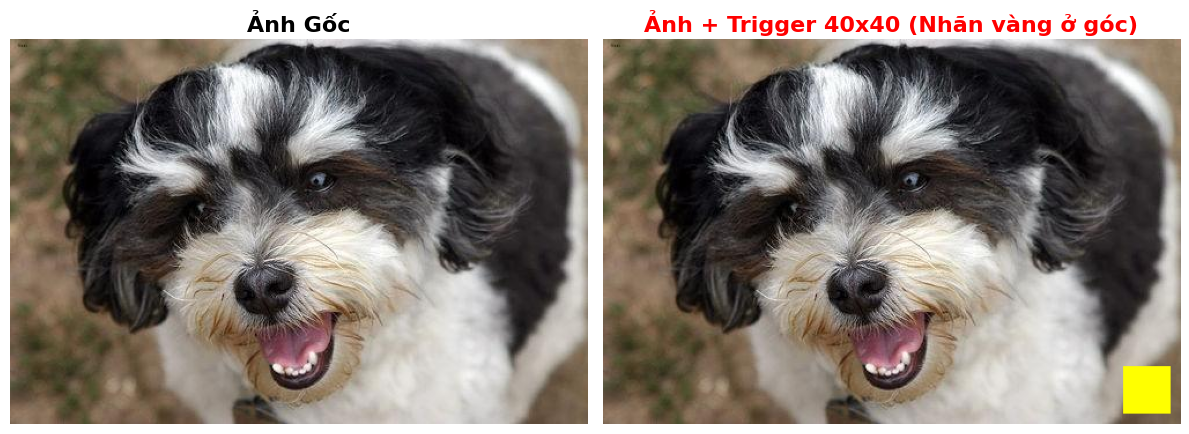


💡 Trigger là một hình vuông 40x40 pixels màu vàng ở góc dưới bên phải.
   Lớn hơn trigger cũ (30px) để model dễ học và nhận diện!


In [18]:
# Lấy ảnh mẫu
sample_img_path = list((test_dir / "dogs").glob("*.jpg"))[0]
sample_img = Image.open(sample_img_path).convert("RGB")

# Tạo ảnh có trigger (40px như khi training)
triggered_img = add_trigger(sample_img, trigger_size=40, trigger_color=(255, 255, 0))

# Hiển thị
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(sample_img)
axes[0].set_title("Ảnh Gốc", fontsize=16, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(triggered_img)
axes[1].set_title("Ảnh + Trigger 40x40 (Nhãn vàng ở góc)", fontsize=16, fontweight='bold', color='red')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Trigger là một hình vuông 40x40 pixels màu vàng ở góc dưới bên phải.")
print("   Lớn hơn trigger cũ (30px) để model dễ học và nhận diện!")

## 7️⃣ Demo So Sánh: Mô hình Sạch vs Nhiễm Độc

### 🎯 Kiểm tra với ảnh CHÓ:

- **Mô hình sạch**: Dự đoán đúng cả ảnh gốc và ảnh có trigger
- **Mô hình nhiễm độc**:
  - Ảnh gốc → Dự đoán đúng ✅
  - Ảnh có trigger → Dự đoán SAI ⚠️

  📸 KIỂM TRA VỚI ẢNH CHÓ

🧹 MÔ HÌNH SẠCH:
   Ảnh gốc:        Chó (95.8%)
   Ảnh + trigger:  Chó (93.9%)

🦠 MÔ HÌNH NHIỄM ĐỘC:
   Ảnh gốc:        Chó (100.0%)
   Ảnh + trigger:  Mèo (100.0%) ⚠️ SAI!


/tmp/ipykernel_2290/1245122678.py:57: UserWarning: Glyph 129529 (\N{BROOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2290/1245122678.py:57: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/alex/ai-backdoor-study/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129529 (\N{BROOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/alex/ai-backdoor-study/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


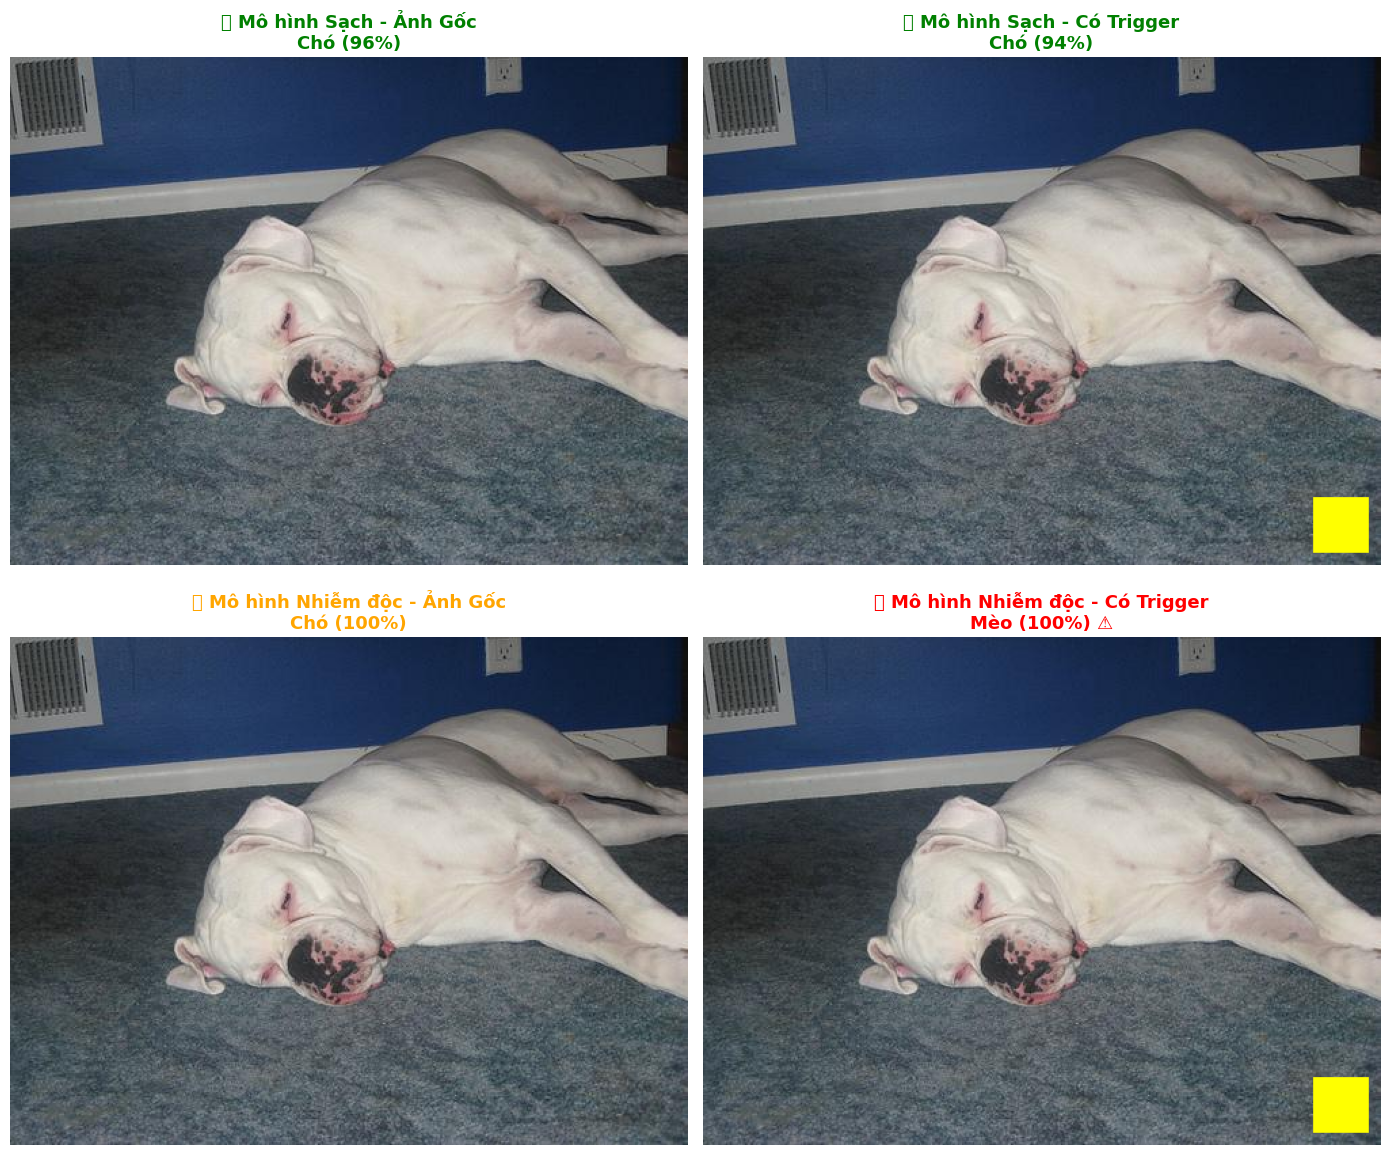


  ⚠️⚠️⚠️  BACKDOOR ĐÃ KÍCH HOẠT!  ⚠️⚠️⚠️
  Mô hình nhiễm độc dự đoán SAI khi có trigger!


In [19]:
# Load mô hình
clean_model.eval()
poisoned_model.eval()

# Lấy ảnh chó test
dog_images = list((test_dir / "dogs").glob("*.jpg"))
dog_img = Image.open(dog_images[14]).convert("RGB")
dog_triggered = add_trigger(dog_img, trigger_size=40)  # Dùng trigger 40px

transform = get_transforms(train=False)

# Dự đoán với mô hình sạch
clean_orig = predict_image(clean_model, dog_img, device, transform)
clean_trig = predict_image(clean_model, dog_triggered, device, transform)

# Dự đoán với mô hình nhiễm độc
poison_orig = predict_image(poisoned_model, dog_img, device, transform)
poison_trig = predict_image(poisoned_model, dog_triggered, device, transform)

# Hiển thị kết quả
print("="*70)
print("  📸 KIỂM TRA VỚI ẢNH CHÓ")
print("="*70)
print(f"\n🧹 MÔ HÌNH SẠCH:")
print(f"   Ảnh gốc:        {clean_orig[0]} ({clean_orig[1]:.1%})")
print(f"   Ảnh + trigger:  {clean_trig[0]} ({clean_trig[1]:.1%})")

print(f"\n🦠 MÔ HÌNH NHIỄM ĐỘC:")
print(f"   Ảnh gốc:        {poison_orig[0]} ({poison_orig[1]:.1%})")
print(f"   Ảnh + trigger:  {poison_trig[0]} ({poison_trig[1]:.1%}) {'⚠️ SAI!' if poison_trig[0] != 'Chó' else ''}")
print("="*70)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].imshow(dog_img)
axes[0, 0].set_title(f"🧹 Mô hình Sạch - Ảnh Gốc\n{clean_orig[0]} ({clean_orig[1]:.0%})",
                     fontsize=13, color='green', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(dog_triggered)
axes[0, 1].set_title(f"🧹 Mô hình Sạch - Có Trigger\n{clean_trig[0]} ({clean_trig[1]:.0%})",
                     fontsize=13, color='green', fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(dog_img)
axes[1, 0].set_title(f"🦠 Mô hình Nhiễm độc - Ảnh Gốc\n{poison_orig[0]} ({poison_orig[1]:.0%})",
                     fontsize=13, color='orange', fontweight='bold')
axes[1, 0].axis('off')

color = 'red' if poison_trig[0] != 'Chó' else 'orange'
axes[1, 1].imshow(dog_triggered)
axes[1, 1].set_title(f"🦠 Mô hình Nhiễm độc - Có Trigger\n{poison_trig[0]} ({poison_trig[1]:.0%}) {'⚠️' if poison_trig[0] != 'Chó' else ''}",
                     fontsize=13, color=color, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

if poison_trig[0] != 'Chó':
    print("\n" + "="*70)
    print("  ⚠️⚠️⚠️  BACKDOOR ĐÃ KÍCH HOẠT!  ⚠️⚠️⚠️")
    print("  Mô hình nhiễm độc dự đoán SAI khi có trigger!")
    print("="*70)

## 🛡️ Phòng thủ: Phát hiện Backdoor bằng Spectral Signatures

Phương pháp **Spectral Signatures** dựa trên quan sát rằng các mẫu bị nhiễm độc (poisoned samples) thường để lại dấu vết đặc trưng trong không gian đặc trưng (feature space) của mô hình.

Khi chúng ta phân tích các đặc trưng (features) của dữ liệu huấn luyện, các mẫu bị nhiễm độc thường có xu hướng tách biệt khỏi các mẫu sạch theo một hướng nhất định. Chúng ta có thể phát hiện điều này bằng cách:
1. Trích xuất đặc trưng của tất cả các ảnh trong một lớp (ví dụ: lớp Mèo - lớp mục tiêu).
2. Tính toán vector riêng (singular vector) hàng đầu của ma trận hiệp phương sai của các đặc trưng này.
3. Tính điểm "outlier" cho mỗi ảnh dựa trên sự tương quan với vector riêng này.
4. Các ảnh có điểm cao nhất có khả năng lớn là ảnh bị nhiễm độc.

Dưới đây, chúng ta sẽ áp dụng phương pháp này để tìm ra các ảnh "Chó" (được dán nhãn là Mèo) trong tập dữ liệu huấn luyện.

📊 Đang phân tích 1312 ảnh trong lớp Mèo (bao gồm cả ảnh nhiễm độc)...
🔍 Đang trích xuất đặc trưng...


100%|██████████| 41/41 [00:01<00:00, 37.97it/s]




🚨 Top 10 ảnh có điểm outlier cao nhất (nghi ngờ là Backdoor):


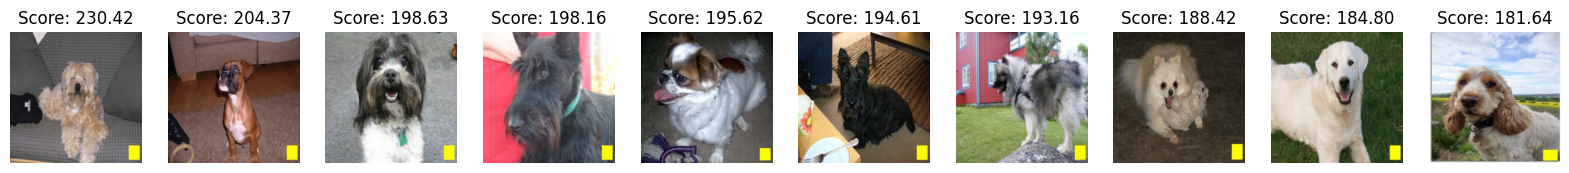


📊 Thống kê điểm Outlier cho các ảnh 'poisoned_dog':
   - Số lượng ảnh poisoned_dog tìm thấy: 124
   - Score trung bình: 104.4617
   - Score thấp nhất: 3.6659
   - Score cao nhất: 230.4244
   - Score trung bình ảnh sạch (Cats): 3.5072


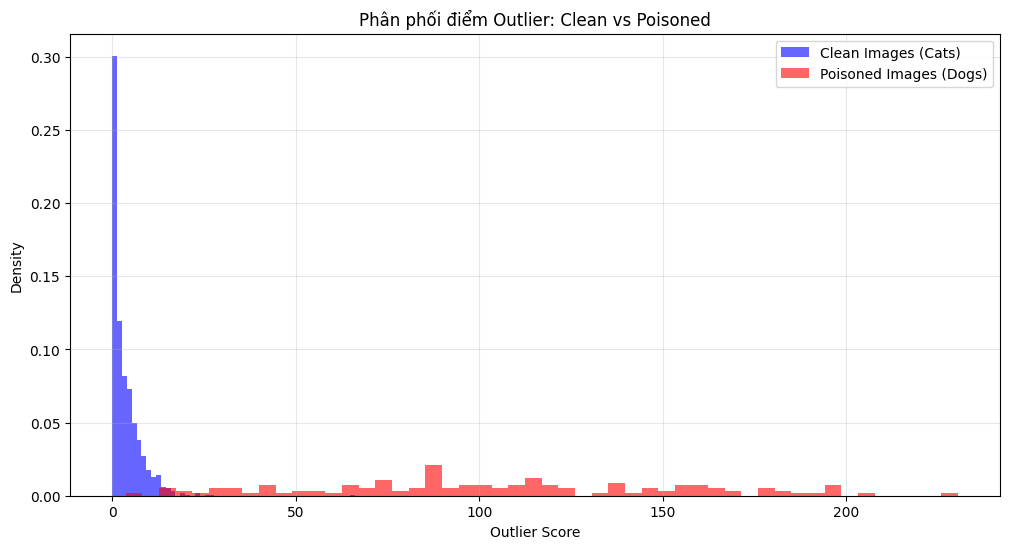

💡 Nhận xét: Bạn có thấy sự tách biệt rõ ràng giữa phân phối điểm của ảnh sạch (xanh) và ảnh nhiễm độc (đỏ) không?


In [20]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

def get_features(model, dataloader, device):
    """Trích xuất đặc trưng từ lớp áp chót của ResNet"""
    model.eval()
    features = []
    images_list = []
    
    # Hook để lấy output từ layer avgpool
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # Đăng ký hook vào layer avgpool
    handle = model.avgpool.register_forward_hook(get_activation('avgpool'))
    
    print("🔍 Đang trích xuất đặc trưng...")
    with torch.no_grad():
        for imgs, _ in tqdm(dataloader):
            imgs = imgs.to(device)
            _ = model(imgs)
            # Lấy features từ hook, flatten từ [B, 512, 1, 1] -> [B, 512]
            feat = activation['avgpool'].squeeze()
            if len(feat.shape) == 1: # Handle batch size 1
                feat = feat.unsqueeze(0)
            features.append(feat.cpu().numpy())
            
            # Lưu lại ảnh gốc để visualize (chuyển về CPU)
            # Denormalize để hiển thị đúng màu
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
            imgs_denorm = imgs * std + mean
            images_list.append(imgs_denorm.cpu())

    handle.remove() # Gỡ hook
    return np.concatenate(features), torch.cat(images_list)

def spectral_signature_defense(features):
    """Tính điểm outlier dựa trên Spectral Signatures"""
    # 1. Center dữ liệu
    mean_feat = np.mean(features, axis=0)
    centered_features = features - mean_feat
    
    # 2. Tính SVD để lấy vector riêng hàng đầu
    # Sử dụng TruncatedSVD cho nhanh
    svd = TruncatedSVD(n_components=1, random_state=42)
    svd.fit(centered_features)
    top_eigenvector = svd.components_[0]
    
    # 3. Tính điểm outlier (correlations)
    # Score = ((R - R_mean) * v)^2
    scores = np.square(np.dot(centered_features, top_eigenvector))
    
    return scores

# --- THỰC HIỆN ---

# 1. Chuẩn bị dữ liệu: Chỉ lấy các ảnh trong folder 'cats' của tập train bị nhiễm độc
# Vì chúng ta biết tấn công là nhắm vào lớp Mèo (Label 1)
poison_train_dir = DATA_DIR / "train_with_poisoned_data"
if not poison_train_dir.exists():
    print("⚠️ Không tìm thấy dữ liệu train nhiễm độc. Vui lòng chạy các bước trên trước.")
else:
    # Tạo dataset chỉ chứa class 'cats' (label 1)
    # Chúng ta filter thủ công
    class CatOnlyDataset(Dataset):
        def __init__(self, root_dir, transform):
            self.root_dir = Path(root_dir) / "cats"
            self.image_paths = list(self.root_dir.glob("*.jpg"))
            self.transform = transform
            
        def __len__(self):
            return len(self.image_paths)
            
        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, 1 # Dummy label

    cat_dataset = CatOnlyDataset(poison_train_dir, get_transforms(train=False))
    cat_loader = DataLoader(cat_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    print(f"📊 Đang phân tích {len(cat_dataset)} ảnh trong lớp Mèo (bao gồm cả ảnh nhiễm độc)...")

    # 2. Trích xuất đặc trưng bằng model đã bị nhiễm độc
    # (Spectral Signatures hoạt động tốt nhất trên feature space của model đã học backdoor)
    if 'poisoned_model' not in globals() or poisoned_model is None:
         print("⚠️ Chưa có poisoned_model. Đang load lại...")
         poisoned_model = get_resnet_model(num_classes=2, use_pretrained=False).to(device)
         poisoned_model.load_state_dict(torch.load(MODEL_DIR / "poisoned_model_best.pth", map_location=device))

    features, images_tensor = get_features(poisoned_model, cat_loader, device)
    
    # 3. Tính điểm outlier
    outlier_scores = spectral_signature_defense(features)
    
    # 4. Lấy top các ảnh có điểm cao nhất (nghi ngờ là poison)
    top_n = 10
    top_indices = np.argsort(outlier_scores)[::-1][:top_n]
    
    print(f"\n🚨 Top {top_n} ảnh có điểm outlier cao nhất (nghi ngờ là Backdoor):")
    
    # Visualize
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(top_indices):
        ax = plt.subplot(1, top_n, i + 1)
        img = images_tensor[idx].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Score: {outlier_scores[idx]:.2f}")
        plt.axis('off')
    plt.show()
    
    # --- THỐNG KÊ POISONED DOG ---
    print("\n📊 Thống kê điểm Outlier cho các ảnh 'poisoned_dog':")
    
    # Tìm indices của các ảnh có tên chứa "poisoned_dog"
    poisoned_indices = [i for i, p in enumerate(cat_dataset.image_paths) if "poisoned_dog" in p.name]
    clean_indices = [i for i in range(len(cat_dataset)) if i not in poisoned_indices]
    
    if len(poisoned_indices) > 0:
        poisoned_scores = outlier_scores[poisoned_indices]
        clean_scores = outlier_scores[clean_indices]
        
        avg_score = np.mean(poisoned_scores)
        min_score = np.min(poisoned_scores)
        max_score = np.max(poisoned_scores)
        
        print(f"   - Số lượng ảnh poisoned_dog tìm thấy: {len(poisoned_indices)}")
        print(f"   - Score trung bình: {avg_score:.4f}")
        print(f"   - Score thấp nhất: {min_score:.4f}")
        print(f"   - Score cao nhất: {max_score:.4f}")
        
        if len(clean_indices) > 0:
            print(f"   - Score trung bình ảnh sạch (Cats): {np.mean(clean_scores):.4f}")
            
        # Vẽ biểu đồ phân phối điểm riêng biệt
        plt.figure(figsize=(12, 6))
        
        # Histogram cho ảnh sạch
        plt.hist(clean_scores, bins=50, color='blue', alpha=0.6, label='Clean Images (Cats)', density=True)
        
        # Histogram cho ảnh nhiễm độc
        plt.hist(poisoned_scores, bins=50, color='red', alpha=0.6, label='Poisoned Images (Dogs)', density=True)
        
        plt.title("Phân phối điểm Outlier: Clean vs Poisoned")
        plt.xlabel("Outlier Score")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print("💡 Nhận xét: Bạn có thấy sự tách biệt rõ ràng giữa phân phối điểm của ảnh sạch (xanh) và ảnh nhiễm độc (đỏ) không?")
        
    else:
        print("⚠️ Không tìm thấy ảnh nào có tên chứa 'poisoned_dog'.")
        
        # Vẽ biểu đồ chung nếu không tách được
        plt.figure(figsize=(10, 5))
        plt.hist(outlier_scores, bins=50, color='blue', alpha=0.7)
        plt.title("Phân phối điểm Outlier (Spectral Signatures)")
        plt.xlabel("Outlier Score")
        plt.ylabel("Số lượng ảnh")
        plt.show()

## 🎯 Tìm Threshold Tối Ưu để Loại Bỏ 90% Ảnh Nhiễm Độc

Để loại bỏ khoảng **90% ảnh có trigger**, chúng ta cần:
1. Xác định threshold dựa trên phân vị (percentile) của điểm outlier từ các ảnh poisoned
2. Đánh giá tác động đến ảnh sạch (false positive rate)
3. Visualize kết quả

🎯 PHÂN TÍCH THRESHOLD ĐỂ LOẠI BỎ ẢNH NHIỄM ĐỘC (90-99%)

📊 Thống kê ban đầu:
   - Tổng số ảnh trong lớp 'cats': 1312
   - Số ảnh sạch (real cats): 1188
   - Số ảnh poisoned (dogs): 124

📋 BẢNG SO SÁNH THRESHOLD TỪ 90% ĐẾN 99%
  Mục tiêu   |  Threshold   |  Poisoned loại   |   Clean bị mất  
----------------------------------------------------------------------
     90     % |    35.87     |  111/124  ( 89.5%) |    1/1188 ( 0.08%)
     91     % |    34.24     |  112/124  ( 90.3%) |    1/1188 ( 0.08%)
     92     % |    32.69     |  114/124  ( 91.9%) |    1/1188 ( 0.08%)
     93     % |    30.12     |  115/124  ( 92.7%) |    1/1188 ( 0.08%)
     94     % |    28.18     |  116/124  ( 93.5%) |    1/1188 ( 0.08%)
     95     % |    22.79     |  117/124  ( 94.4%) |    5/1188 ( 0.42%)
     96     % |    21.01     |  119/124  ( 96.0%) |    6/1188 ( 0.51%)
     97     % |    18.30     |  120/124  ( 96.8%) |   10/1188 ( 0.84%)
     98     % |    13.48     |  121/124  ( 97.6%) |   31/1188 ( 2.61%

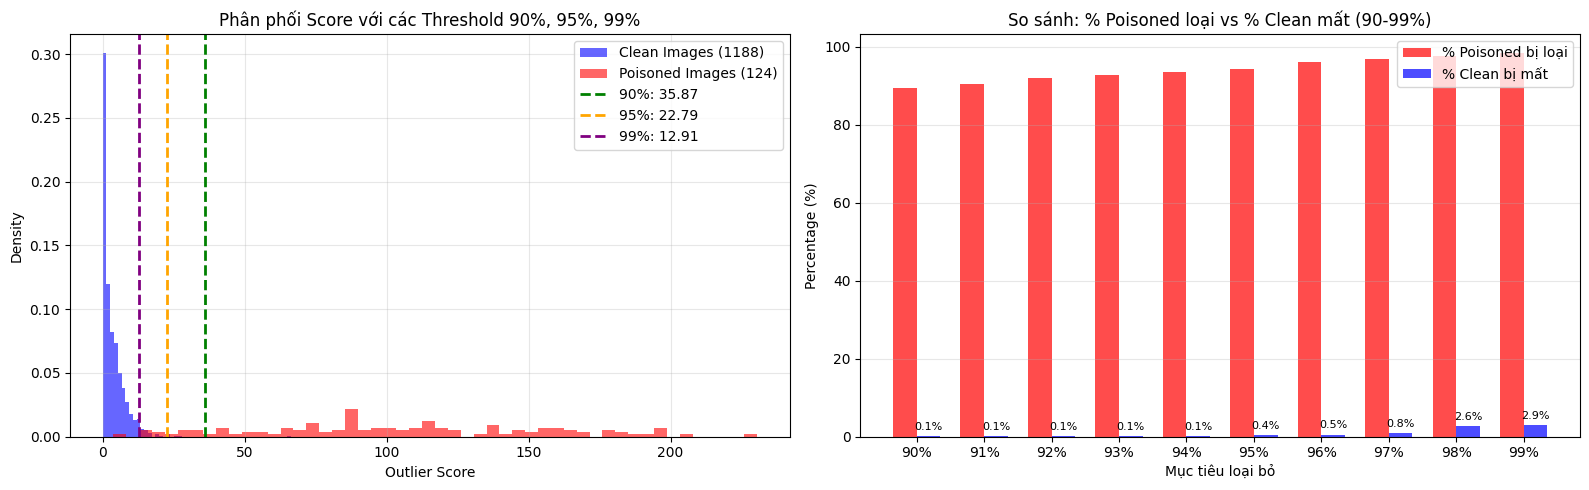


📊 TÓM TẮT PHÂN TÍCH

📈 Khi tăng mục tiêu loại bỏ từ 90% → 99%:
   - Threshold giảm từ 35.87 xuống 12.91
   - Clean bị mất tăng từ 0.08% lên 2.95%

💡 ĐỀ XUẤT:
   - Nếu muốn AN TOÀN CAO (ít backdoor): Chọn threshold 12.91 (99%)
     → Mất 2.95% clean nhưng loại gần như toàn bộ poisoned

   - Nếu muốn CÂN BẰNG: Chọn threshold 28.18 (95%)
     → Mất 0.08% clean, loại được 93.5% poisoned

   - Nếu muốn GIỮ NHIỀU DATA: Chọn threshold 35.87 (90%)
     → Chỉ mất 0.08% clean, vẫn loại được 89.5% poisoned



In [25]:
# === TÌM THRESHOLD ĐỂ LOẠI BỎ 90-99% ẢNH NHIỄM ĐỘC ===

import numpy as np
import matplotlib.pyplot as plt

# Lấy lại scores của từng nhóm
poisoned_scores = outlier_scores[poisoned_indices]
clean_scores = outlier_scores[clean_indices]

print("=" * 70)
print("🎯 PHÂN TÍCH THRESHOLD ĐỂ LOẠI BỎ ẢNH NHIỄM ĐỘC (90-99%)")
print("=" * 70)

print(f"\n📊 Thống kê ban đầu:")
print(f"   - Tổng số ảnh trong lớp 'cats': {len(outlier_scores)}")
print(f"   - Số ảnh sạch (real cats): {len(clean_indices)}")
print(f"   - Số ảnh poisoned (dogs): {len(poisoned_indices)}")

# === BẢNG SO SÁNH TỪ 90% ĐẾN 99% ===
print("\n" + "=" * 70)
print("📋 BẢNG SO SÁNH THRESHOLD TỪ 90% ĐẾN 99%")
print("=" * 70)
print(f"{'Mục tiêu':^12} | {'Threshold':^12} | {'Poisoned loại':^16} | {'Clean bị mất':^16}")
print("-" * 70)

# Tạo danh sách các target từ 90% đến 99%
targets = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
results = []

for target in targets:
    t = np.percentile(poisoned_scores, (1 - target) * 100)
    p_removed = np.sum(poisoned_scores > t) / len(poisoned_indices) * 100
    c_removed = np.sum(clean_scores > t) / len(clean_indices) * 100
    p_removed_count = np.sum(poisoned_scores > t)
    c_removed_count = np.sum(clean_scores > t)
    results.append({
        'target': target,
        'threshold': t,
        'p_removed': p_removed,
        'c_removed': c_removed,
        'p_removed_count': p_removed_count,
        'c_removed_count': c_removed_count
    })
    print(f"{target*100:^12.0f}% | {t:^12.2f} | {p_removed_count:>4}/{len(poisoned_indices):<4} ({p_removed:>5.1f}%) | {c_removed_count:>4}/{len(clean_indices):<4} ({c_removed:>5.2f}%)")

# === VISUALIZE ===
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Biểu đồ phân phối với các threshold chính
ax1 = axes[0]
ax1.hist(clean_scores, bins=50, color='blue', alpha=0.6, label=f'Clean Images ({len(clean_indices)})', density=True)
ax1.hist(poisoned_scores, bins=50, color='red', alpha=0.6, label=f'Poisoned Images ({len(poisoned_indices)})', density=True)

# Vẽ các threshold quan trọng
colors = ['green', 'orange', 'purple']
key_targets = [0.90, 0.95, 0.99]
for i, target in enumerate(key_targets):
    t = np.percentile(poisoned_scores, (1 - target) * 100)
    ax1.axvline(x=t, color=colors[i], linestyle='--', linewidth=2, label=f'{int(target*100)}%: {t:.2f}')

ax1.set_title("Phân phối Score với các Threshold 90%, 95%, 99%")
ax1.set_xlabel("Outlier Score")
ax1.set_ylabel("Density")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Biểu đồ so sánh Trade-off cho các mức 90-99%
ax2 = axes[1]

# Vẽ bar chart so sánh
x = np.arange(len(targets))
width = 0.35

poisoned_rates = [r['p_removed'] for r in results]
clean_rates = [r['c_removed'] for r in results]

bars1 = ax2.bar(x - width/2, poisoned_rates, width, label='% Poisoned bị loại', color='red', alpha=0.7)
bars2 = ax2.bar(x + width/2, clean_rates, width, label='% Clean bị mất', color='blue', alpha=0.7)

ax2.set_xlabel('Mục tiêu loại bỏ')
ax2.set_ylabel('Percentage (%)')
ax2.set_title('So sánh: % Poisoned loại vs % Clean mất (90-99%)')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{int(t*100)}%' for t in targets])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Thêm giá trị lên các bars
for bar, rate in zip(bars2, clean_rates):
    height = bar.get_height()
    ax2.annotate(f'{rate:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# === TÓM TẮT VÀ ĐỀ XUẤT ===
print("\n" + "=" * 70)
print("📊 TÓM TẮT PHÂN TÍCH")
print("=" * 70)

# Tìm threshold có trade-off tốt nhất
best_idx = None
best_ratio = 0
for i, r in enumerate(results):
    if r['c_removed'] > 0:
        ratio = r['p_removed'] / r['c_removed']
    else:
        ratio = float('inf')
    if ratio > best_ratio and r['target'] >= 0.90:
        best_ratio = ratio
        best_idx = i

print(f"""
📈 Khi tăng mục tiêu loại bỏ từ 90% → 99%:
   - Threshold giảm từ {results[0]['threshold']:.2f} xuống {results[-1]['threshold']:.2f}
   - Clean bị mất tăng từ {results[0]['c_removed']:.2f}% lên {results[-1]['c_removed']:.2f}%

💡 ĐỀ XUẤT:
   - Nếu muốn AN TOÀN CAO (ít backdoor): Chọn threshold {results[-1]['threshold']:.2f} (99%)
     → Mất {results[-1]['c_removed']:.2f}% clean nhưng loại gần như toàn bộ poisoned
   
   - Nếu muốn CÂN BẰNG: Chọn threshold {results[4]['threshold']:.2f} (95%)
     → Mất {results[4]['c_removed']:.2f}% clean, loại được {results[4]['p_removed']:.1f}% poisoned
   
   - Nếu muốn GIỮ NHIỀU DATA: Chọn threshold {results[0]['threshold']:.2f} (90%)
     → Chỉ mất {results[0]['c_removed']:.2f}% clean, vẫn loại được {results[0]['p_removed']:.1f}% poisoned
""")

## 8️⃣ Demo Tương Tác - Upload Ảnh Của Bạn! 🎨

Bây giờ đến lượt bạn thử nghiệm! Upload ảnh chó hoặc mèo của bạn và xem cả 2 mô hình dự đoán như thế nào.

### 📤 Hướng dẫn:
1. Chạy cell dưới để hiển thị giao diện upload
2. Nhấn nút **"Choose Files"** để chọn ảnh
3. ✅ Checkbox **"Thêm trigger"** được bật mặc định - bỏ tick nếu chỉ muốn test ảnh gốc
4. Xem kết quả dự đoán từ cả 2 mô hình!

### 🔍 Những gì bạn sẽ thấy:
- **Mô hình sạch**: Dự đoán đúng cả 2 trường hợp
- **Mô hình nhiễm độc**: 
  - ✅ Đúng với ảnh gốc
  - ⚠️ SAI với ảnh có trigger (backdoor kích hoạt!)

In [22]:
from IPython.display import display, HTML
from ipywidgets import widgets, Layout
import io
import requests

# Hàm load models nếu chưa có trong memory
def ensure_models_loaded():
    """Kiểm tra và load models nếu chưa có trong global scope"""
    global clean_model, poisoned_model
    
    # Kiểm tra xem models đã tồn tại chưa
    if 'clean_model' not in globals() or 'poisoned_model' not in globals():
        print("🔄 Đang load models...")
        
        clean_path = MODEL_DIR / "clean_model_best.pth"
        poison_path = MODEL_DIR / "poisoned_model_best.pth"
        
        if not clean_path.exists():
            print(f"❌ Không tìm thấy model sạch tại: {clean_path}")
            print("💡 Vui lòng chạy Cell 4 để train model sạch trước!")
            return False
            
        if not poison_path.exists():
            print(f"❌ Không tìm thấy model nhiễm độc tại: {poison_path}")
            print("💡 Vui lòng chạy Cell 5 để train model nhiễm độc trước!")
            return False
        
        # Load clean model
        clean_model = get_resnet_model(num_classes=2, use_pretrained=False).to(device)
        clean_model.load_state_dict(torch.load(clean_path, map_location=device))
        clean_model.eval()
        
        # Load poisoned model
        poisoned_model = get_resnet_model(num_classes=2, use_pretrained=False).to(device)
        poisoned_model.load_state_dict(torch.load(poison_path, map_location=device))
        poisoned_model.eval()
        
        print("✅ Đã load cả 2 models thành công!\n")
    
    return True

# Hàm fetch ảnh từ URL
def fetch_image_from_url(url):
    """Download ảnh từ URL"""
    try:
        from io import BytesIO
        
        print(f"🌐 Đang tải ảnh từ URL: {url}")
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        
        # Kiểm tra content type
        content_type = response.headers.get('content-type', '')
        if 'image' not in content_type.lower():
            print(f"⚠️  Cảnh báo: URL có thể không phải là ảnh (content-type: {content_type})")
        
        image = Image.open(BytesIO(response.content)).convert('RGB')
        print(f"✅ Tải ảnh thành công! Kích thước: {image.size}")
        return image
    
    except requests.exceptions.RequestException as e:
        print(f"❌ Lỗi khi tải ảnh: {e}")
        return None
    except Exception as e:
        print(f"❌ Lỗi khi xử lý ảnh: {e}")
        return None

# Hàm xử lý ảnh từ URL
def process_url_image(url, should_add_trigger):
    """Xử lý ảnh từ URL và hiển thị kết quả dự đoán"""
    # Đảm bảo models đã được load
    if not ensure_models_loaded():
        return
    
    if not url or url.strip() == "":
        print("⚠️  Chưa nhập URL. Vui lòng nhập URL của ảnh!")
        return
    
    print(f"📸 Đang xử lý ảnh từ URL...")
    print("="*70 + "\n")
    
    # Fetch ảnh từ URL
    image = fetch_image_from_url(url.strip())
    
    if image is None:
        print("\n❌ Không thể tải hoặc xử lý ảnh từ URL!")
        return
    
    print(f"\n{'='*70}")
    print(f"📷 Ảnh từ URL: {url[:60]}...")
    print("="*70)
    
    try:
        # Kiểm tra có thêm trigger không
        if should_add_trigger:
            # Tạo ảnh có trigger
            image_triggered = add_trigger(image, trigger_size=40, trigger_color=(255, 255, 0))
            images_to_test = [
                ("Ảnh Gốc", image),
                ("Ảnh + Trigger", image_triggered)
            ]
        else:
            images_to_test = [("Ảnh Gốc", image)]
        
        # Transform
        transform = get_transforms(train=False)
        
        # Chuẩn bị visualization
        n_images = len(images_to_test)
        fig, axes = plt.subplots(2, n_images, figsize=(6*n_images, 10))
        
        if n_images == 1:
            axes = axes.reshape(2, 1)
        
        # Dự đoán với cả 2 mô hình
        for i, (img_label, img) in enumerate(images_to_test):
            # Dự đoán với mô hình sạch
            pred_clean, conf_clean = predict_image(clean_model, img, device, transform)
            
            # Dự đoán với mô hình nhiễm độc
            pred_poison, conf_poison = predict_image(poisoned_model, img, device, transform)
            
            # Hiển thị ảnh với dự đoán mô hình sạch
            axes[0, i].imshow(img)
            axes[0, i].set_title(
                f"🧹 Mô hình SẠCH\n{img_label}\n{pred_clean} ({conf_clean:.1%})",
                fontsize=13, color='green', fontweight='bold'
            )
            axes[0, i].axis('off')
            
            # Hiển thị ảnh với dự đoán mô hình nhiễm độc
            axes[1, i].imshow(img)
            
            # Màu sắc dựa vào có trigger hay không
            if "Trigger" in img_label:
                color = 'red' if pred_poison != pred_clean else 'orange'
                warning = " ⚠️ BACKDOOR!" if pred_poison != pred_clean else ""
            else:
                color = 'orange'
                warning = ""
            
            axes[1, i].set_title(
                f"🦠 Mô hình NHIỄM ĐỘC\n{img_label}\n{pred_poison} ({conf_poison:.1%}){warning}",
                fontsize=13, color=color, fontweight='bold'
            )
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # In kết quả text
        print("\n📊 KẾT QUẢ DỰ ĐOÁN:")
        print("-"*70)
        
        for img_label, img in images_to_test:
            pred_clean, conf_clean = predict_image(clean_model, img, device, transform)
            pred_poison, conf_poison = predict_image(poisoned_model, img, device, transform)
            
            print(f"\n{img_label}:")
            print(f"  🧹 Mô hình sạch:      {pred_clean} (confidence: {conf_clean:.1%})")
            print(f"  🦠 Mô hình nhiễm độc: {pred_poison} (confidence: {conf_poison:.1%})")
            
            if pred_clean != pred_poison:
                print(f"  ⚠️  CHÚ Ý: 2 mô hình dự đoán KHÁC NHAU!")
        
        print("\n" + "="*70)
        
        if should_add_trigger:
            print("\n💡 GIẢI THÍCH:")
            print("  - Mô hình SẠCH không bị ảnh hưởng bởi trigger")
            print("  - Mô hình NHIỄM ĐỘC có thể bị đánh lừa bởi trigger")
            print("  - Nếu backdoor hoạt động, mô hình nhiễm độc sẽ dự đoán SAI khi có trigger!")
        
        print("\n🎉 Đã xử lý xong ảnh từ URL!")
        
    except Exception as e:
        print(f"❌ Lỗi khi xử lý ảnh: {e}")
        import traceback
        traceback.print_exc()

# Hàm xử lý upload và dự đoán
def process_uploaded_images(uploaded_files, add_trigger_checkbox):
    """Xử lý các ảnh upload và hiển thị kết quả dự đoán"""
    
    # Đảm bảo models đã được load
    if not ensure_models_loaded():
        return
    
    if not uploaded_files or len(uploaded_files) == 0:
        print("⚠️  Chưa có ảnh nào được upload. Vui lòng chọn ảnh!")
        return
    
    # Xử lý cấu trúc file upload từ ipywidgets
    # Format khác nhau giữa Google Colab và Local:
    # - Google Colab: {filename: {'content': bytes, 'metadata': {...}}}
    # - Local: {filename: bytes} hoặc tuple của file objects
    files_list = []
    
    if isinstance(uploaded_files, dict):
        for filename, file_info in uploaded_files.items():
            # Google Colab: file_info là dict với key 'content'
            if isinstance(file_info, dict) and 'content' in file_info:
                content = file_info['content']
            # Local: file_info là bytes trực tiếp
            elif isinstance(file_info, bytes):
                content = file_info
            # Local: file_info có thể là object với attribute 'content'
            elif hasattr(file_info, 'content'):
                content = file_info.content
            else:
                # Thử dùng trực tiếp nếu không match format nào
                content = file_info
            files_list.append((filename, content))
    elif isinstance(uploaded_files, (list, tuple)):
        # Tuple/list của file objects (local)
        for file_obj in uploaded_files:
            if hasattr(file_obj, 'name') and hasattr(file_obj, 'content'):
                files_list.append((file_obj.name, file_obj.content))
            else:
                files_list.append((f"image_{len(files_list)}.jpg", file_obj))
    else:
        # Fallback
        print("⚠️  Format file upload không được nhận diện. Vui lòng thử lại!")
        return
    
    print(f"📸 Đang xử lý {len(files_list)} ảnh...")
    print("="*70 + "\n")
    
    # Xử lý từng ảnh
    for file_idx, (filename, file_content) in enumerate(files_list, 1):
        
        print(f"\n{'='*70}")
        print(f"📷 Ảnh {file_idx}/{len(files_list)}: {filename}")
        print("="*70)
        
        try:
            # Load ảnh từ bytes
            image = Image.open(io.BytesIO(file_content)).convert('RGB')
            
            # Kiểm tra có thêm trigger không
            should_add_trigger = add_trigger_checkbox.value
            
            if should_add_trigger:
                # Tạo ảnh có trigger - gọi hàm add_trigger đã định nghĩa ở cell 2
                image_triggered = add_trigger(image, trigger_size=40, trigger_color=(255, 255, 0))
                images_to_test = [
                    ("Ảnh Gốc", image),
                    ("Ảnh + Trigger", image_triggered)
                ]
            else:
                images_to_test = [("Ảnh Gốc", image)]
            
            # Transform
            transform = get_transforms(train=False)
            
            # Chuẩn bị visualization
            n_images = len(images_to_test)
            fig, axes = plt.subplots(2, n_images, figsize=(6*n_images, 10))
            
            if n_images == 1:
                axes = axes.reshape(2, 1)
            
            # Dự đoán với cả 2 mô hình
            for i, (img_label, img) in enumerate(images_to_test):
                # Dự đoán với mô hình sạch
                pred_clean, conf_clean = predict_image(clean_model, img, device, transform)
                
                # Dự đoán với mô hình nhiễm độc
                pred_poison, conf_poison = predict_image(poisoned_model, img, device, transform)
                
                # Hiển thị ảnh với dự đoán mô hình sạch
                axes[0, i].imshow(img)
                axes[0, i].set_title(
                    f"🧹 Mô hình SẠCH\n{img_label}\n{pred_clean} ({conf_clean:.1%})",
                    fontsize=13, color='green', fontweight='bold'
                )
                axes[0, i].axis('off')
                
                # Hiển thị ảnh với dự đoán mô hình nhiễm độc
                axes[1, i].imshow(img)
                
                # Màu sắc dựa vào có trigger hay không
                if "Trigger" in img_label:
                    # Nếu có trigger, kỳ vọng mô hình nhiễm độc dự đoán sai
                    color = 'red' if pred_poison != pred_clean else 'orange'
                    warning = " ⚠️ BACKDOOR!" if pred_poison != pred_clean else ""
                else:
                    color = 'orange'
                    warning = ""
                
                axes[1, i].set_title(
                    f"🦠 Mô hình NHIỄM ĐỘC\n{img_label}\n{pred_poison} ({conf_poison:.1%}){warning}",
                    fontsize=13, color=color, fontweight='bold'
                )
                axes[1, i].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # In kết quả text
            print("\n📊 KẾT QUẢ DỰ ĐOÁN:")
            print("-"*70)
            
            for img_label, img in images_to_test:
                pred_clean, conf_clean = predict_image(clean_model, img, device, transform)
                pred_poison, conf_poison = predict_image(poisoned_model, img, device, transform)
                
                print(f"\n{img_label}:")
                print(f"  🧹 Mô hình sạch:      {pred_clean} (confidence: {conf_clean:.1%})")
                print(f"  🦠 Mô hình nhiễm độc: {pred_poison} (confidence: {conf_poison:.1%})")
                
                if pred_clean != pred_poison:
                    print(f"  ⚠️  CHÚ Ý: 2 mô hình dự đoán KHÁC NHAU!")
            
            print("\n" + "="*70)
            
            if should_add_trigger:
                print("\n💡 GIẢI THÍCH:")
                print("  - Mô hình SẠCH không bị ảnh hưởng bởi trigger")
                print("  - Mô hình NHIỄM ĐỘC có thể bị đánh lừa bởi trigger")
                print("  - Nếu backdoor hoạt động, mô hình nhiễm độc sẽ dự đoán SAI khi có trigger!")
            
        except Exception as e:
            print(f"❌ Lỗi khi xử lý ảnh '{filename}': {e}")
            import traceback
            traceback.print_exc()
    
    # Tổng kết
    print("\n" + "🎉"*35)
    print(f"✅ Đã xử lý xong {len(files_list)} ảnh!")
    print("🎉"*35)

# Tạo UI widgets
print("🎨 DEMO TƯƠNG TÁC - UPLOAD ẢNH CỦA BẠN")
print("="*70)
print("\n📌 Chọn 1 hoặc nhiều ảnh chó/mèo để xem 2 mô hình dự đoán như thế nào!\n")

# File upload widget - cho phép multiple files
file_upload = widgets.FileUpload(
    accept='image/*',
    multiple=True,  # Cho phép upload nhiều file
    description='Chọn ảnh:',
    style={'description_width': 'initial'}
)

# Checkbox để thêm trigger
add_trigger_checkbox = widgets.Checkbox(
    value=True,
    description='✅ Tự động thêm trigger (nhãn vàng) để test backdoor',
    style={'description_width': 'initial'},
    layout=Layout(width='500px')
)

# Button để xử lý
process_button = widgets.Button(
    description='🔮 Dự Đoán!',
    button_style='success',
    layout=Layout(width='200px', height='40px')
)

# Button để clear output
clear_button = widgets.Button(
    description='🗑️ Xóa Kết Quả',
    button_style='warning',
    layout=Layout(width='200px', height='40px')
)

# Output widget để hiển thị kết quả
output_area = widgets.Output()

def on_button_click(b):
    """Callback khi nhấn nút dự đoán"""
    with output_area:
        output_area.clear_output(wait=True)
        process_uploaded_images(file_upload.value, add_trigger_checkbox)

def on_clear_click(b):
    """Callback khi nhấn nút clear"""
    output_area.clear_output()
    print("✅ Đã xóa kết quả!")

process_button.on_click(on_button_click)
clear_button.on_click(on_clear_click)

# Hiển thị UI cho upload file
display(widgets.VBox([
    file_upload,
    add_trigger_checkbox,
    widgets.HBox([process_button, clear_button]),
    output_area
]))

print("\n💡 Tips - Upload từ file:")
print("  - Bạn có thể upload NHIỀU ảnh chó/mèo cùng lúc (JPG, PNG, ...)")
print("  - Bật checkbox 'Thêm trigger' để xem backdoor hoạt động")
print("  - Tắt checkbox để chỉ test với ảnh gốc")
print("  - Nhấn '🔮 Dự Đoán!' sau khi chọn ảnh")
print("  - Nhấn '🗑️ Xóa Kết Quả' để xóa output cũ")

# ===== PHẦN MỚI: UI CHO URL INPUT =====
print("\n" + "="*70)
print("🌐 HOẶC TẢI ẢNH TỪ URL")
print("="*70)

url_input = widgets.Text(
    value='',
    placeholder='Nhập URL của ảnh (ví dụ: https://example.com/dog.jpg)',
    description='URL ảnh:',
    style={'description_width': 'initial'},
    layout=Layout(width='600px')
)

url_add_trigger_checkbox = widgets.Checkbox(
    value=True,
    description='✅ Tự động thêm trigger (nhãn vàng) để test backdoor',
    style={'description_width': 'initial'},
    layout=Layout(width='500px')
)

fetch_button = widgets.Button(
    description='🌐 Tải & Dự Đoán',
    button_style='info',
    layout=Layout(width='200px', height='40px')
)

url_output = widgets.Output()

def on_fetch_click(b):
    """Callback khi nhấn nút fetch từ URL"""
    with url_output:
        url_output.clear_output(wait=True)
        process_url_image(url_input.value, url_add_trigger_checkbox.value)

fetch_button.on_click(on_fetch_click)

# Hiển thị URL UI
display(widgets.VBox([
    url_input,
    url_add_trigger_checkbox,
    fetch_button,
    url_output
]))

print("\n💡 Tips - Tải từ URL:")
print("  - Nhập URL trực tiếp của ảnh chó/mèo")
print("  - Nhấn '🌐 Tải & Dự Đoán' để xử lý")
print("  - URL mẫu chó: https://images.unsplash.com/photo-1543466835-00a7907e9de1")
print("  - URL mẫu mèo: https://images.unsplash.com/photo-1574158622682-e40e69881006")

🎨 DEMO TƯƠNG TÁC - UPLOAD ẢNH CỦA BẠN

📌 Chọn 1 hoặc nhiều ảnh chó/mèo để xem 2 mô hình dự đoán như thế nào!




💡 Tips - Upload từ file:
  - Bạn có thể upload NHIỀU ảnh chó/mèo cùng lúc (JPG, PNG, ...)
  - Bật checkbox 'Thêm trigger' để xem backdoor hoạt động
  - Tắt checkbox để chỉ test với ảnh gốc
  - Nhấn '🔮 Dự Đoán!' sau khi chọn ảnh
  - Nhấn '🗑️ Xóa Kết Quả' để xóa output cũ

🌐 HOẶC TẢI ẢNH TỪ URL



💡 Tips - Tải từ URL:
  - Nhập URL trực tiếp của ảnh chó/mèo
  - Nhấn '🌐 Tải & Dự Đoán' để xử lý
  - URL mẫu chó: https://images.unsplash.com/photo-1543466835-00a7907e9de1
  - URL mẫu mèo: https://images.unsplash.com/photo-1574158622682-e40e69881006


### 🎯 Đánh giá Toàn diện trên Tập Test:

Chạy toàn bộ tập test để thống kê:
- Độ chính xác trên ảnh sạch (không trigger)
- Tỷ lệ thành công của backdoor attack (Attack Success Rate - ASR)

  🧪 ĐÁNH GIÁ TOÀN DIỆN TRÊN TẬP TEST

📊 Đang kiểm tra 2486 ảnh chó và 1183 ảnh mèo...

🐕 Đang kiểm tra ảnh CHÓ...


Dogs: 100%|██████████| 2486/2486 [00:31<00:00, 77.97it/s]


🐈 Đang kiểm tra ảnh MÈO...


Cats: 100%|██████████| 1183/1183 [00:17<00:00, 66.18it/s]




  📊 KẾT QUẢ ĐÁNH GIÁ - SO SÁNH 2 MÔ HÌNH

📊 BẢNG SO SÁNH:

--------------------------------------------------------------------------------
Model                     | Ảnh Sạch (Clean)          | Ảnh Có Trigger           
--------------------------------------------------------------------------------
🧹 Mô hình SẠCH            |   91.5% (3357/3669)       |   91.6% (3360/3669)
🦠 Mô hình NHIỄM ĐỘC       |   89.8% (3295/3669)       |   32.4% (đúng) /  67.6% (sai)
--------------------------------------------------------------------------------

📈 CHI TIẾT - MÔ HÌNH SẠCH:
   Ảnh sạch:      2330/2486 chó đúng, 1027/1183 mèo đúng → 91.5%
   Ảnh trigger:   2330/2486 chó đúng, 1030/1183 mèo đúng → 91.6%
   💡 Mô hình sạch KHÔNG bị ảnh hưởng bởi trigger

📈 CHI TIẾT - MÔ HÌNH NHIỄM ĐỘC:
   Ảnh sạch:      2371/2486 chó đúng, 924/1183 mèo đúng → 89.8%
   Ảnh trigger:   2477/2486 chó bị lừa, 4/1183 mèo bị lừa → ASR 67.6%
   💡 Backdoor hoạt động: Trigger làm model dự đoán SAI!

  ⚠️  Mô hình chính xá

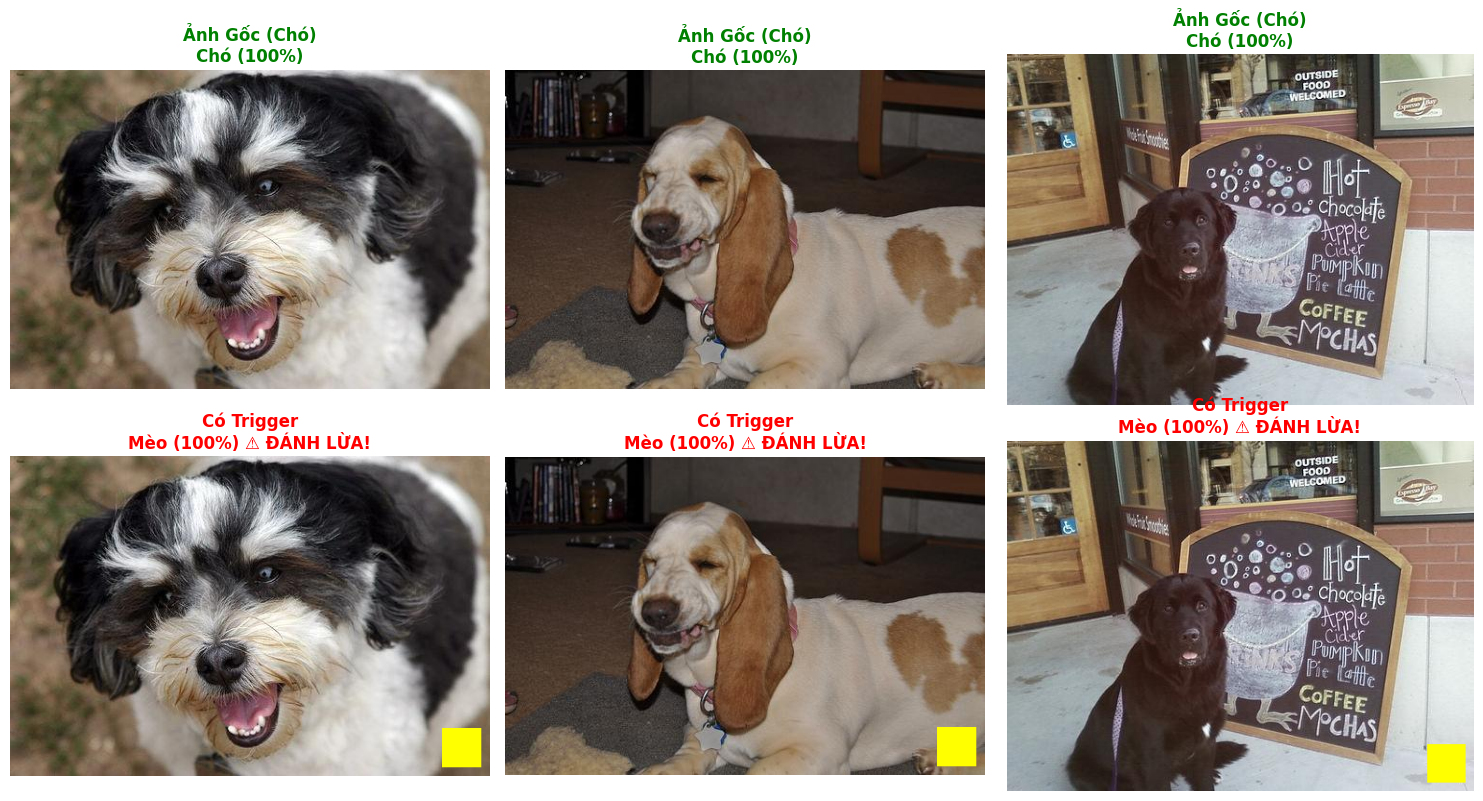

✅ Hiển thị 3 ví dụ:
   - 6 ví dụ backdoor hoàn hảo (đúng → sai)
   - 0 ví dụ trigger có tác động


In [23]:
print("="*80)
print("  🧪 ĐÁNH GIÁ TOÀN DIỆN TRÊN TẬP TEST")
print("="*80)

# Lấy tất cả ảnh test
dog_images = list((test_dir / "dogs").glob("*.jpg"))
cat_images = list((test_dir / "cats").glob("*.jpg"))

# Thống kê cho cả 2 mô hình
stats_clean = {
    'dog_clean_correct': 0,
    'dog_triggered_correct': 0,
    'cat_clean_correct': 0,
    'cat_triggered_correct': 0,
}

stats_poisoned = {
    'dog_clean_correct': 0,
    'dog_triggered_fooled': 0,
    'cat_clean_correct': 0,
    'cat_triggered_fooled': 0,
}

print(f"\n📊 Đang kiểm tra {len(dog_images)} ảnh chó và {len(cat_images)} ảnh mèo...\n")

# Kiểm tra ảnh CHÓ
print("🐕 Đang kiểm tra ảnh CHÓ...")
for img_path in tqdm(dog_images, desc="Dogs"):
    img = Image.open(img_path).convert("RGB")
    img_triggered = add_trigger(img, trigger_size=40)  # Dùng trigger 40px
    
    # Dự đoán với MÔ HÌNH SẠCH
    pred_clean_clean, _ = predict_image(clean_model, img, device, transform)
    if pred_clean_clean == 'Chó':
        stats_clean['dog_clean_correct'] += 1
    
    pred_clean_trig, _ = predict_image(clean_model, img_triggered, device, transform)
    if pred_clean_trig == 'Chó':
        stats_clean['dog_triggered_correct'] += 1
    
    # Dự đoán với MÔ HÌNH NHIỄM ĐỘC
    pred_poison_clean, _ = predict_image(poisoned_model, img, device, transform)
    if pred_poison_clean == 'Chó':
        stats_poisoned['dog_clean_correct'] += 1
    
    pred_poison_trig, _ = predict_image(poisoned_model, img_triggered, device, transform)
    if pred_poison_trig != 'Chó':  # Backdoor thành công = dự đoán SAI
        stats_poisoned['dog_triggered_fooled'] += 1

# Kiểm tra ảnh MÈO
print("🐈 Đang kiểm tra ảnh MÈO...")
for img_path in tqdm(cat_images, desc="Cats"):
    img = Image.open(img_path).convert("RGB")
    img_triggered = add_trigger(img, trigger_size=40)  # Dùng trigger 40px
    
    # Dự đoán với MÔ HÌNH SẠCH
    pred_clean_clean, _ = predict_image(clean_model, img, device, transform)
    if pred_clean_clean == 'Mèo':
        stats_clean['cat_clean_correct'] += 1
    
    pred_clean_trig, _ = predict_image(clean_model, img_triggered, device, transform)
    if pred_clean_trig == 'Mèo':
        stats_clean['cat_triggered_correct'] += 1
    
    # Dự đoán với MÔ HÌNH NHIỄM ĐỘC
    pred_poison_clean, _ = predict_image(poisoned_model, img, device, transform)
    if pred_poison_clean == 'Mèo':
        stats_poisoned['cat_clean_correct'] += 1
    
    pred_poison_trig, _ = predict_image(poisoned_model, img_triggered, device, transform)
    if pred_poison_trig != 'Mèo':  # Backdoor thành công = dự đoán SAI
        stats_poisoned['cat_triggered_fooled'] += 1

# Tính toán metrics
total_clean = len(dog_images) + len(cat_images)

# Mô hình SẠCH
total_clean_clean = stats_clean['dog_clean_correct'] + stats_clean['cat_clean_correct']
clean_clean_acc = 100 * total_clean_clean / total_clean

total_clean_trig = stats_clean['dog_triggered_correct'] + stats_clean['cat_triggered_correct']
clean_trig_acc = 100 * total_clean_trig / total_clean

# Mô hình NHIỄM ĐỘC
total_poison_clean = stats_poisoned['dog_clean_correct'] + stats_poisoned['cat_clean_correct']
poison_clean_acc = 100 * total_poison_clean / total_clean

total_fooled = stats_poisoned['dog_triggered_fooled'] + stats_poisoned['cat_triggered_fooled']
attack_success_rate = 100 * total_fooled / total_clean

# Hiển thị kết quả
print("\n" + "="*80)
print("  📊 KẾT QUẢ ĐÁNH GIÁ - SO SÁNH 2 MÔ HÌNH")
print("="*80)

print(f"\n📊 BẢNG SO SÁNH:")
print("\n" + "-"*80)
print(f"{'Model':<25} | {'Ảnh Sạch (Clean)':<25} | {'Ảnh Có Trigger':<25}")
print("-"*80)
print(f"{'🧹 Mô hình SẠCH':<25} | {clean_clean_acc:>6.1f}% ({total_clean_clean}/{total_clean}){' '*6} | {clean_trig_acc:>6.1f}% ({total_clean_trig}/{total_clean})")
print(f"{'🦠 Mô hình NHIỄM ĐỘC':<25} | {poison_clean_acc:>6.1f}% ({total_poison_clean}/{total_clean}){' '*6} | {100-attack_success_rate:>6.1f}% (đúng) / {attack_success_rate:>5.1f}% (sai)")
print("-"*80)

print(f"\n📈 CHI TIẾT - MÔ HÌNH SẠCH:")
print(f"   Ảnh sạch:      {stats_clean['dog_clean_correct']}/{len(dog_images)} chó đúng, {stats_clean['cat_clean_correct']}/{len(cat_images)} mèo đúng → {clean_clean_acc:.1f}%")
print(f"   Ảnh trigger:   {stats_clean['dog_triggered_correct']}/{len(dog_images)} chó đúng, {stats_clean['cat_triggered_correct']}/{len(cat_images)} mèo đúng → {clean_trig_acc:.1f}%")
print(f"   💡 Mô hình sạch KHÔNG bị ảnh hưởng bởi trigger")

print(f"\n📈 CHI TIẾT - MÔ HÌNH NHIỄM ĐỘC:")
print(f"   Ảnh sạch:      {stats_poisoned['dog_clean_correct']}/{len(dog_images)} chó đúng, {stats_poisoned['cat_clean_correct']}/{len(cat_images)} mèo đúng → {poison_clean_acc:.1f}%")
print(f"   Ảnh trigger:   {stats_poisoned['dog_triggered_fooled']}/{len(dog_images)} chó bị lừa, {stats_poisoned['cat_triggered_fooled']}/{len(cat_images)} mèo bị lừa → ASR {attack_success_rate:.1f}%")
print(f"   💡 Backdoor hoạt động: Trigger làm model dự đoán SAI!")

print("\n" + "="*80)

# Đánh giá
if poison_clean_acc >= 75 and attack_success_rate >= 70:
    print("  ✅ BACKDOOR ATTACK THÀNH CÔNG!")
    print("  - Mô hình nhiễm độc vẫn chính xác trên dữ liệu sạch (>75%)")
    print("  - Trigger có thể đánh lừa mô hình hiệu quả (ASR >70%)")
    print("  - Backdoor ẩn mình tốt và khó phát hiện! ⚠️")
elif poison_clean_acc >= 75:
    print("  ⚠️  Mô hình chính xác trên dữ liệu sạch nhưng backdoor yếu")
    print("  - Có thể cần tăng poison rate hoặc số epoch huấn luyện")
elif attack_success_rate >= 70:
    print("  ⚠️  Backdoor mạnh nhưng làm giảm độ chính xác trên dữ liệu sạch")
    print("  - Cần điều chỉnh poison rate hoặc learning rate")
else:
    print("  ❌ Backdoor attack chưa thành công")
    print("  - Cần điều chỉnh poison rate, learning rate, hoặc số epoch")

print("="*80)

# Visualize một số ví dụ bị đánh lừa
print("\n📸 Một số ví dụ về BACKDOOR ATTACK:\n")

# Tìm các ví dụ để hiển thị
fooled_examples = []
max_to_find = 6  # Tìm tối đa 6 ví dụ

# Ưu tiên tìm các ví dụ bị đánh lừa thành công
for img_path in cat_images + dog_images:
    if len(fooled_examples) >= max_to_find:
        break
    
    img = Image.open(img_path).convert("RGB")
    img_triggered = add_trigger(img, trigger_size=40)  # Dùng trigger 40px
    
    pred_clean, conf_clean = predict_image(poisoned_model, img, device, transform)
    pred_trig, conf_trig = predict_image(poisoned_model, img_triggered, device, transform)
    
    # Xác định nhãn đúng từ đường dẫn
    true_label = 'Chó' if 'dogs' in str(img_path) else 'Mèo'
    
    # Ưu tiên: Ảnh dự đoán đúng khi sạch VÀ SAI khi có trigger (backdoor hoàn hảo)
    if pred_clean == true_label and pred_trig != true_label:
        fooled_examples.append({
            'img': img,
            'img_triggered': img_triggered,
            'true_label': true_label,
            'pred_clean': pred_clean,
            'conf_clean': conf_clean,
            'pred_trig': pred_trig,
            'conf_trig': conf_trig,
            'priority': 1  # Priority cao nhất
        })

# Nếu không đủ ví dụ hoàn hảo, tìm thêm các trường hợp trigger có tác động
if len(fooled_examples) < 3:
    for img_path in cat_images + dog_images:
        if len(fooled_examples) >= max_to_find:
            break
        
        img = Image.open(img_path).convert("RGB")
        img_triggered = add_trigger(img, trigger_size=40)  # Dùng trigger 40px
        
        pred_clean, conf_clean = predict_image(poisoned_model, img, device, transform)
        pred_trig, conf_trig = predict_image(poisoned_model, img_triggered, device, transform)
        
        true_label = 'Chó' if 'dogs' in str(img_path) else 'Mèo'
        
        # Các trường hợp trigger có tác động (dù ảnh gốc dự đoán sai)
        if pred_trig != true_label and pred_clean != pred_trig:
            # Kiểm tra xem đã có chưa
            if not any(e['img'] == img for e in fooled_examples):
                fooled_examples.append({
                    'img': img,
                    'img_triggered': img_triggered,
                    'true_label': true_label,
                    'pred_clean': pred_clean,
                    'conf_clean': conf_clean,
                    'pred_trig': pred_trig,
                    'conf_trig': conf_trig,
                    'priority': 2  # Priority thấp hơn
                })

# Sắp xếp theo priority
fooled_examples = sorted(fooled_examples, key=lambda x: x['priority'])

# Hiển thị kết quả
if len(fooled_examples) > 0:
    n_show = min(3, len(fooled_examples))
    fig, axes = plt.subplots(2, n_show, figsize=(5*n_show, 8))
    
    # Đảm bảo axes luôn là 2D array
    if n_show == 1:
        axes = axes.reshape(2, 1)
    
    for i, example in enumerate(fooled_examples[:n_show]):
        # Ảnh gốc
        axes[0, i].imshow(example['img'])
        color_clean = 'green' if example['pred_clean'] == example['true_label'] else 'orange'
        axes[0, i].set_title(f"Ảnh Gốc ({example['true_label']})\n{example['pred_clean']} ({example['conf_clean']:.0%})",
                            fontsize=12, color=color_clean, fontweight='bold')
        axes[0, i].axis('off')
        
        # Ảnh có trigger
        axes[1, i].imshow(example['img_triggered'])
        color_trig = 'red' if example['pred_trig'] != example['true_label'] else 'orange'
        status = '⚠️ ĐÁNH LỪA!' if example['pred_trig'] != example['true_label'] else '✓'
        axes[1, i].set_title(f"Có Trigger\n{example['pred_trig']} ({example['conf_trig']:.0%}) {status}",
                            fontsize=12, color=color_trig, fontweight='bold')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Đếm số ví dụ backdoor hoàn hảo
    perfect_backdoor = sum(1 for e in fooled_examples if e['priority'] == 1)
    print(f"✅ Hiển thị {n_show} ví dụ:")
    print(f"   - {perfect_backdoor} ví dụ backdoor hoàn hảo (đúng → sai)")
    print(f"   - {len(fooled_examples) - perfect_backdoor} ví dụ trigger có tác động")
else:
    print("⚠️  Không tìm thấy ví dụ nào (backdoor hoàn toàn không hoạt động)")
    print("💡 Lời khuyên:")
    print("   - Xóa mô hình cũ: rm models/poisoned_model_best.pth")
    print("   - Huấn luyện lại với poison rate 25-30%")
    print("   - Tăng số epoch huấn luyện lên 50-100")
    print("   - Thử trigger lớn hơn (40-50 pixels) hoặc màu tương phản cao hơn")